# Phi->ee ML analysis

# STARlight parser

In [1]:
import pandas as pd

def parse_starlight_output(file_path):
    events = []
    vertices = []
    tracks = []
    
    with open(file_path, 'r') as file:
        current_event = None
        current_vertex = None
        
        for line in file:
            if line.startswith("EVENT"):
                if current_event:
                    events.append(current_event)
                event_data = line.split()
                current_event = {
                    "Event Number": int(event_data[1]),
                    "Number of Tracks": int(event_data[2]),
                    "Number of Vertices": int(event_data[3]),
                    "Vertices": [],
                    "Tracks": []
                }
            elif line.startswith("VERTEX"):
                vertex_data = line.split()
                current_vertex = {
                    "x": float(vertex_data[1]),
                    "y": float(vertex_data[2]),
                    "z": float(vertex_data[3]),
                    "t": float(vertex_data[4]),
                    "Vertex Number": int(vertex_data[5]),
                    "Process Number": int(vertex_data[6]),
                    "Parent Track": int(vertex_data[7]),
                    "Number of Daughters": int(vertex_data[8])
                }
                current_event["Vertices"].append(current_vertex)
            elif line.startswith("TRACK"):
                track_data = line.split()
                track = {
                    "GPID": int(track_data[1]),
                    "px": float(track_data[2]),
                    "py": float(track_data[3]),
                    "pz": float(track_data[4]),
                    "Event Number": int(track_data[5]),
                    "Track Number": int(track_data[6]),
                    "Stop Vertex": int(track_data[7]),
                    "PDGPID": int(track_data[8])
                }
                current_event["Tracks"].append(track)
        
        if current_event:
            events.append(current_event)
    
    # Flatten the data into lists of dictionaries for DataFrame conversion
    event_list = []
    vertex_list = []
    track_list = []
    
    for event in events:
        event_list.append({
            "Event Number": event["Event Number"],
            "Number of Tracks": event["Number of Tracks"],
            "Number of Vertices": event["Number of Vertices"]
        })
        
        for vertex in event["Vertices"]:
            vertex["Event Number"] = event["Event Number"]
            vertex_list.append(vertex)
        
        for track in event["Tracks"]:
            track_list.append(track)
    
    # Convert to DataFrames
    event_df = pd.DataFrame(event_list)
    vertex_df = pd.DataFrame(vertex_list)
    track_df = pd.DataFrame(track_list)
    
    return event_df, vertex_df, track_df

# Example usage:
# event_df, vertex_df, track_df = parse_starlight_output('starlight_output.txt')

# Display the dataframes
# print(event_df.head())
# print(vertex_df.head())
# print(track_df.head())


In [2]:
import pandas as pd
import numpy as np
from scipy.constants import c
import vector


# Assuming the parse_starlight_output function from the previous code has been defined

def group_tracks_by_event(track_df):
    grouped_tracks = track_df.groupby('Event Number').apply(lambda x: x.to_dict(orient='records'), include_groups=False).to_dict()
    return grouped_tracks


def create_lorentz_vector(px, py, pz, mass):
    vec = vector.obj(px=px, py=py, pz=pz, E=(px**2 + py**2 + pz**2 + mass**2)**0.5)
    return vec


def get_mass_from_pdgid(pdgid):
    # This function would return the mass based on PDG ID
    # For simplicity, assuming some common particle masses
    pdg_masses = {
        11: 0.000511,  # Electron mass in GeV/c^2
        13: 0.10566,   # Muon mass in GeV/c^2
        211: 0.13957,  # Pion mass in GeV/c^2
        # Add more particles as needed
    }
    return pdg_masses.get(abs(pdgid), 0)  # Default to 0 if mass is unknown


# def perform_operations_on_event(grouped_tracks):
#     """
#     Creates a DataFrame with all Lorentz vectors for each event using the vector package.

#     Parameters:
#     grouped_tracks (dict): A dictionary where keys are event numbers and values are lists of track dictionaries.

#     Returns:
#     DataFrame: A DataFrame with columns ['Event Number', 'Track Number', 'Energy', 'px', 'py', 'pz'].
#     """
#     daughters_list = []
#     mothers_list = []

#     for event_number, event_tracks in grouped_tracks.items():
#         mother = create_lorentz_vector(0., 0., 0., 0.)
#         for track in event_tracks:
#             mass = get_mass_from_pdgid(track['PDGPID'])
#             vec = create_lorentz_vector(track['px'], track['py'], track['pz'], mass)
#             daughters_list.append({
#                 'Event Number': event_number,
#                 'Track Number': track['Track Number'],
#                 'Energy': vec.E,
#                 'px': vec.px,
#                 'py': vec.py,
#                 'pz': vec.pz
#             })
#             mother += vec
#         mothers_list.append({
#             'mother': mother,
#             'Energy': mother.E,
#             'px': mother.px,
#             'py': mother.py,
#             'pz': mother.pz
#         })

#     # Create DataFrame
#     daughters_df = pd.DataFrame(daughters_list)
#     mothers_df = pd.DataFrame(mothers_list)

#     return daughters_df, mothers_df


def apply_smearing(momentum):
    """
    Applies Gaussian smearing to a momentum component.
    
    Parameters:
    momentum (float): Original momentum component (px, py, or pz).
    resolution_params (dict): Parameters for smearing, e.g., {"a": 0.01, "b": 0.05}.
    
    Returns:
    float: Smeared momentum component.
    """
    a = 0.0025
    b = 0.005
    sigma = np.sqrt((a * momentum)**2 + b**2)  # Resolution formula
    return np.random.normal(momentum, sigma)


def perform_operations_on_event(grouped_tracks):
    """
    Creates a DataFrame with all Lorentz vectors for each event using the vector package.

    Parameters:
    grouped_tracks (dict): A dictionary where keys are event numbers and values are lists of track dictionaries.

    Returns:
    DataFrame: A DataFrame with columns ['Event Number', 'Track Number', 'Energy', 'px', 'py', 'pz'].
    """
    daughters_list = []
    mothers_list = []

    for event_number, event_tracks in grouped_tracks.items():
        mother = create_lorentz_vector(0., 0., 0., 0.)
        for track in event_tracks:
            mass = get_mass_from_pdgid(track['PDGPID'])
            vec = create_lorentz_vector(track['px'], track['py'], track['pz'], mass)
            # smeared_px = apply_smearing(track['px'])
            # smeared_py = apply_smearing(track['py'])
            # smeared_pz = apply_smearing(track['pz'])

            # vec = create_lorentz_vector(smeared_px, smeared_py, smeared_pz, mass)

            daughters_list.append({
                'Event Number': event_number,
                'Track Number': track['Track Number'],
                'Energy': vec.E,
                'px': vec.px,
                'py': vec.py,
                'pz': vec.pz
            })
            mother += vec
        mothers_list.append({
            'mother': mother,
            'Energy': mother.E,
            'px': mother.px,
            'py': mother.py,
            'pz': mother.pz
        })

    # Create DataFrame
    daughters_df = pd.DataFrame(daughters_list)
    mothers_df = pd.DataFrame(mothers_list)

    return daughters_df, mothers_df


In [3]:
event_df_gg, vertex_df_gg, track_df_gg = parse_starlight_output('slight-gg.out')
grouped_tracks_gg = group_tracks_by_event(track_df_gg)
daughters_gg_df, gg_df = perform_operations_on_event(grouped_tracks_gg)
print(gg_df.head())


                                              mother    Energy        px  \
0  MomentumObject4D(px=0.002374000000000015, py=0...  2.605134  0.002374   
1  MomentumObject4D(px=-0.03393200000000002, py=-...  1.011372 -0.033932   
2  MomentumObject4D(px=0.03916300000000006, py=-0...  1.638124  0.039163   
3  MomentumObject4D(px=-0.048740000000000006, py=...  2.768532 -0.048740   
4  MomentumObject4D(px=0.00892900000000002, py=-0...  1.453469  0.008929   

         py        pz  
0  0.000150  1.883961  
1 -0.068489 -0.083270  
2 -0.023573 -0.099818  
3 -0.008025 -0.626137  
4 -0.014635 -0.436247  


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mass_and_pt_distribution(df):
    """
    Plots the mass distribution and transverse momentum distribution from a DataFrame.

    Parameters:
    df (DataFrame): Input DataFrame with columns 'mother', 'Energy', 'px', 'py', 'pz'.
    """

    # Calculate the mass and transverse momentum (p_T) for each row
    df['mass'] = df['mother'].apply(lambda v: v.mass)
    df['pt'] = df['mother'].apply(lambda v: v.pt)

    # Create a figure with two subplots
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))

    # Plot the mass distribution
    ax[0].hist(df['mass'], bins=50, color='blue', alpha=0.7)
    ax[0].set_title('Mass Distribution')
    ax[0].set_xlabel('Mass (GeV/c^2)')
    ax[0].set_ylabel('Frequency')

    # Plot the transverse momentum distribution
    ax[1].hist(df['pt'], bins=50, color='green', alpha=0.7)
    ax[1].set_title('Transverse Momentum Distribution')
    ax[1].set_xlabel('p_T (GeV/c)')
    ax[1].set_ylabel('Frequency')

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming df is your input DataFrame with a 'mother' column containing vector objects
# plot_mass_and_pt_distribution(df)


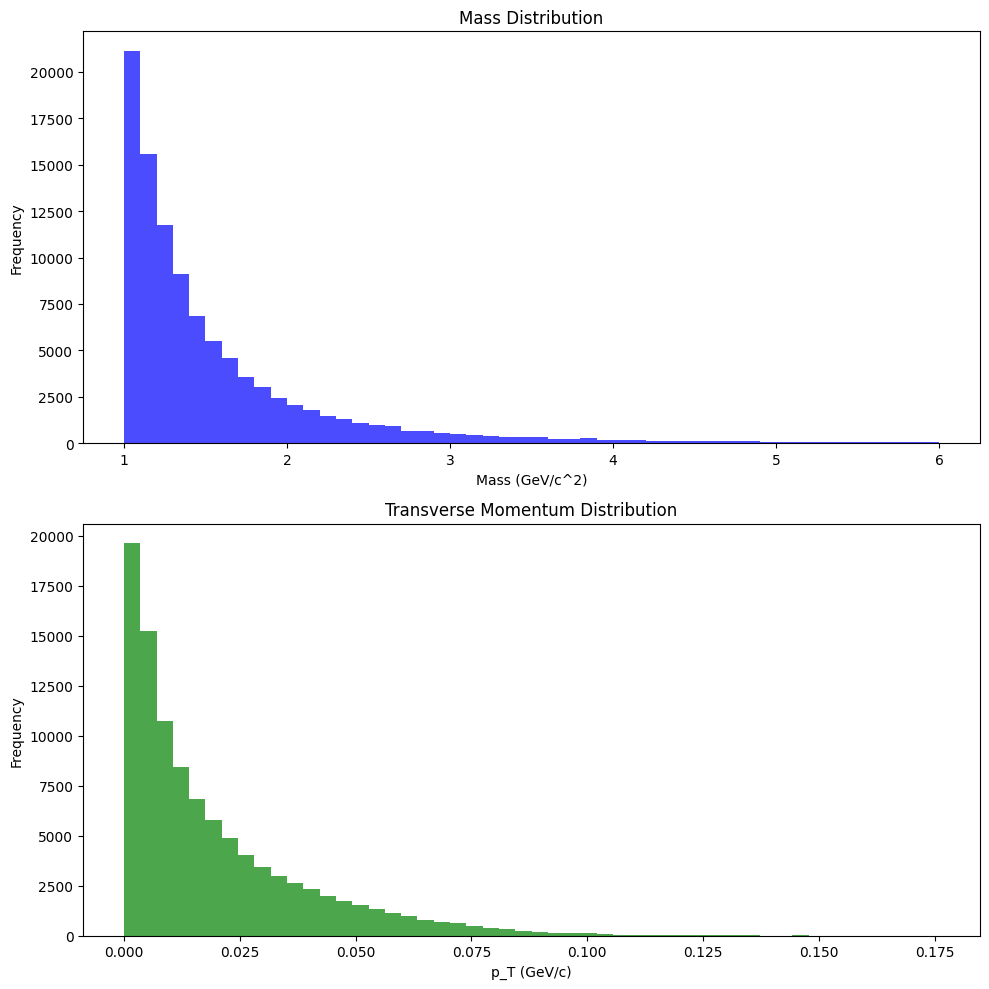

In [5]:
plot_mass_and_pt_distribution(gg_df)

In [6]:
print(daughters_gg_df.head())

   Event Number  Track Number    Energy        px        py        pz
0             1             0  1.266138  0.140385 -0.888044  0.891502
1             1             1  1.338996 -0.138011  0.888194  0.992459
2             2             0  0.521857  0.289636 -0.432667 -0.035278
3             2             1  0.489515 -0.323568  0.364178 -0.047992
4             3             0  0.829362 -0.660527  0.045974 -0.499432


In [7]:
event_df, vertex_df, track_df = parse_starlight_output('slight-phi-ee.out')
grouped_tracks = group_tracks_by_event(track_df)
daughters_df, phi_df = perform_operations_on_event(grouped_tracks)
print(phi_df.head())


                                              mother    Energy        px  \
0  MomentumObject4D(px=-0.004143754936030031, py=...  1.090508 -0.004144   
1  MomentumObject4D(px=0.0012064162009839952, py=...  1.046055  0.001206   
2  MomentumObject4D(px=0.025883832960793995, py=0...  1.032061  0.025884   
3  MomentumObject4D(px=0.02610563303184299, py=0....  1.136266  0.026106   
4  MomentumObject4D(px=-0.066394104308874, py=-0....  1.052234 -0.066394   

         py        pz  
0  0.049471 -0.384927  
1  0.035765 -0.197011  
2  0.006824  0.134575  
3  0.040723 -0.494031  
4 -0.022258 -0.249178  


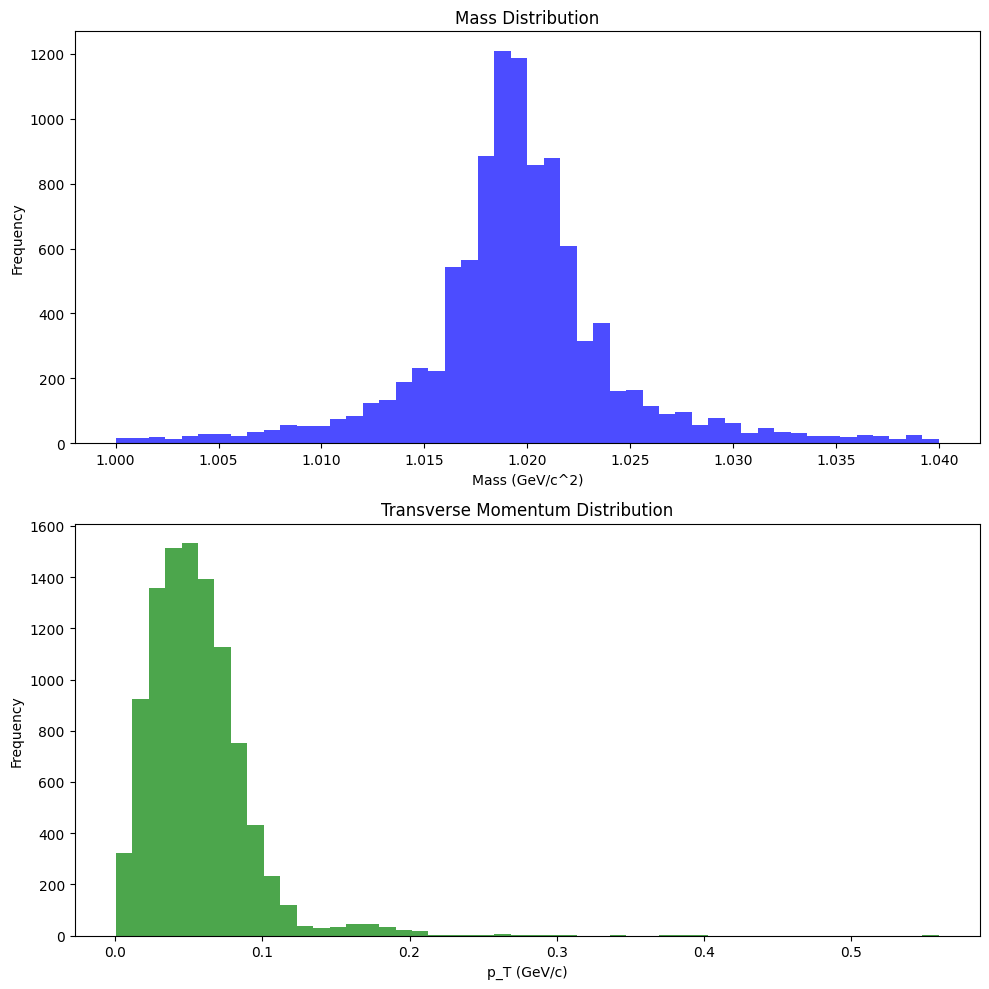

In [8]:
plot_mass_and_pt_distribution(phi_df)

In [9]:
print(daughters_df.head())

   Event Number  Track Number    Energy        px        py        pz
0             1             0  0.563738  0.504080  0.054365 -0.246471
1             1             1  0.526769 -0.508224 -0.004894 -0.138455
2             2             0  0.517686  0.358347  0.373597 -0.003376
3             2             1  0.528369 -0.357141 -0.337831 -0.193635
4             3             0  0.542333 -0.306291 -0.285068  0.345032


#### Checking distributions

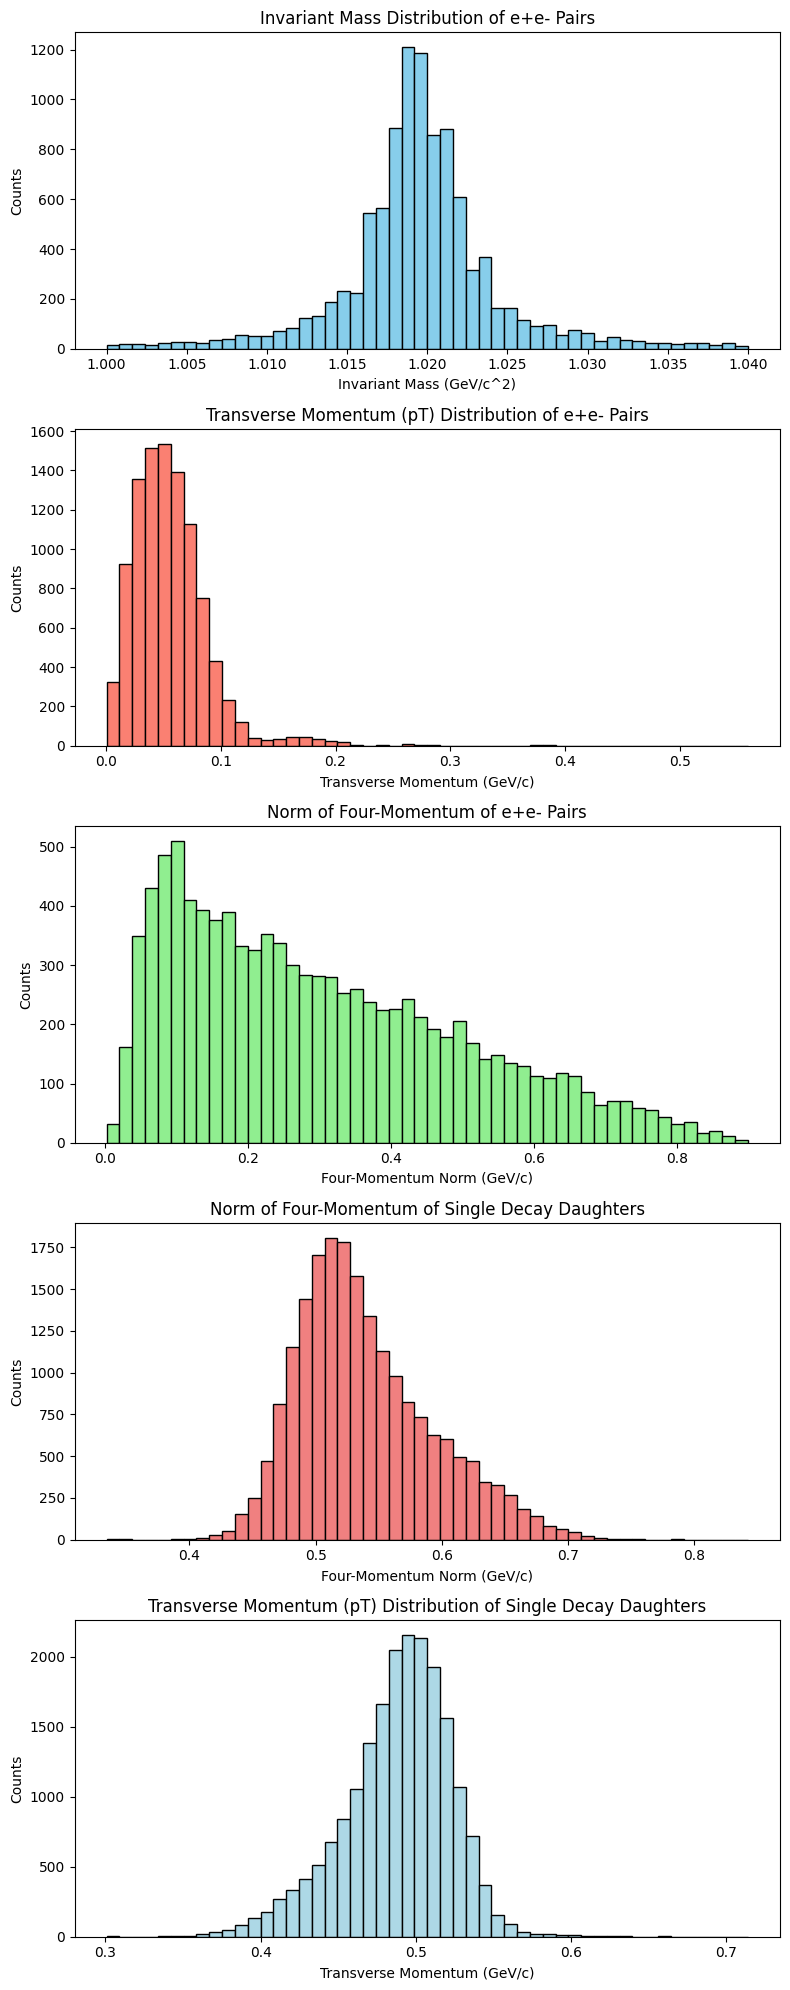

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_distributions_from_daughters(daughters_df):
    """
    Plots invariant mass, transverse momentum, and four-momentum norms of e+e- pairs 
    and single decay daughters based on the input DataFrame.
    
    Parameters:
    daughters_df (pd.DataFrame): DataFrame containing daughter particle information with 
                                 columns ['Event Number', 'Track Number', 'Energy', 'px', 'py', 'pz'].
    """
    # Group by event number to sum electron and positron four-momenta
    grouped = daughters_df.groupby('Event Number')
    
    # Calculate four-momentum components for e+e- pairs
    px_ee = grouped['px'].sum()
    py_ee = grouped['py'].sum()
    pz_ee = grouped['pz'].sum()
    energy_ee = grouped['Energy'].sum()
    
    # Invariant mass of e+e- pairs
    invariant_mass = np.sqrt(energy_ee**2 - (px_ee**2 + py_ee**2 + pz_ee**2))
    
    # Transverse momentum of e+e- pairs
    pt_ee_pairs = np.sqrt(px_ee**2 + py_ee**2)
    
    # Norm of four-momentum of e+e- pairs
    four_momentum_norm_ee_pairs = np.sqrt(px_ee**2 + py_ee**2 + pz_ee**2)
    
    # For single decay daughters
    four_momentum_norm_single = np.sqrt(daughters_df['px']**2 + daughters_df['py']**2 + daughters_df['pz']**2)
    pt_single = np.sqrt(daughters_df['px']**2 + daughters_df['py']**2)

    # Plotting
    fig, axs = plt.subplots(5, 1, figsize=(8, 20))

    axs[0].hist(invariant_mass, bins=50, color='skyblue', edgecolor='black')
    axs[0].set_title("Invariant Mass Distribution of e+e- Pairs")
    axs[0].set_xlabel("Invariant Mass (GeV/c^2)")
    axs[0].set_ylabel("Counts")

    axs[1].hist(pt_ee_pairs, bins=50, color='salmon', edgecolor='black')
    axs[1].set_title("Transverse Momentum (pT) Distribution of e+e- Pairs")
    axs[1].set_xlabel("Transverse Momentum (GeV/c)")
    axs[1].set_ylabel("Counts")

    axs[2].hist(four_momentum_norm_ee_pairs, bins=50, color='lightgreen', edgecolor='black')
    axs[2].set_title("Norm of Four-Momentum of e+e- Pairs")
    axs[2].set_xlabel("Four-Momentum Norm (GeV/c)")
    axs[2].set_ylabel("Counts")

    axs[3].hist(four_momentum_norm_single, bins=50, color='lightcoral', edgecolor='black')
    axs[3].set_title("Norm of Four-Momentum of Single Decay Daughters")
    axs[3].set_xlabel("Four-Momentum Norm (GeV/c)")
    axs[3].set_ylabel("Counts")

    axs[4].hist(pt_single, bins=50, color='lightblue', edgecolor='black')
    axs[4].set_title("Transverse Momentum (pT) Distribution of Single Decay Daughters")
    axs[4].set_xlabel("Transverse Momentum (GeV/c)")
    axs[4].set_ylabel("Counts")

    plt.tight_layout()
    plt.show()

# Example usage:
plot_distributions_from_daughters(daughters_df)


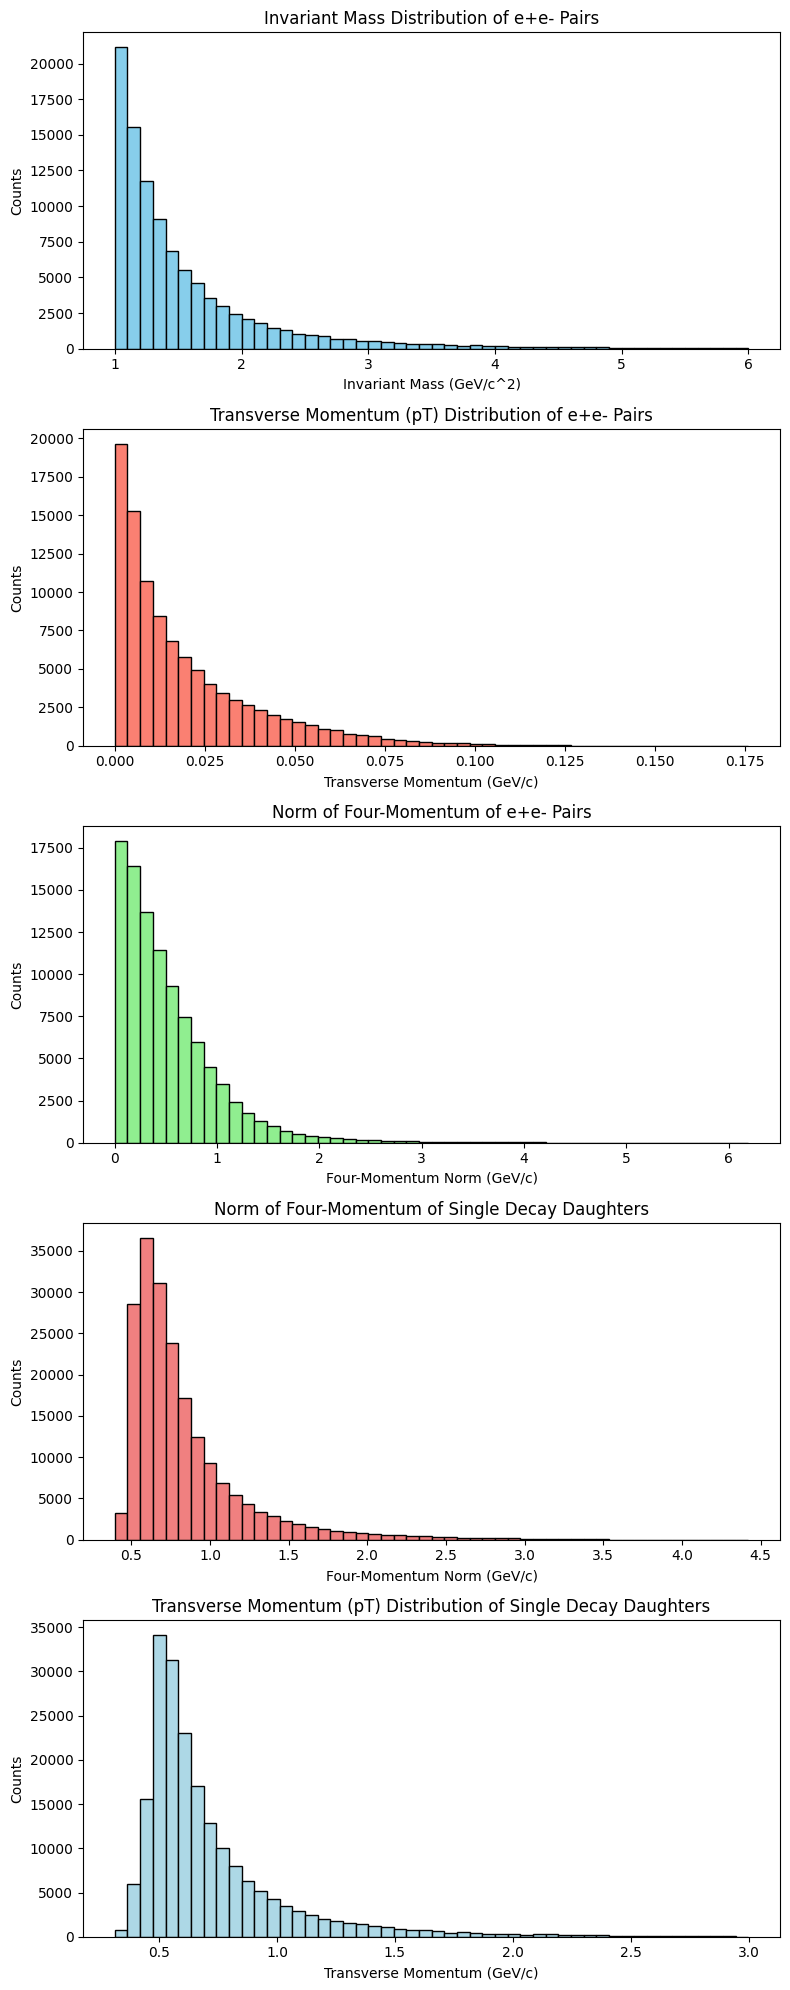

In [11]:
plot_distributions_from_daughters(daughters_gg_df)

### Checking multiple features tht could be fed as input to the ML algorithm

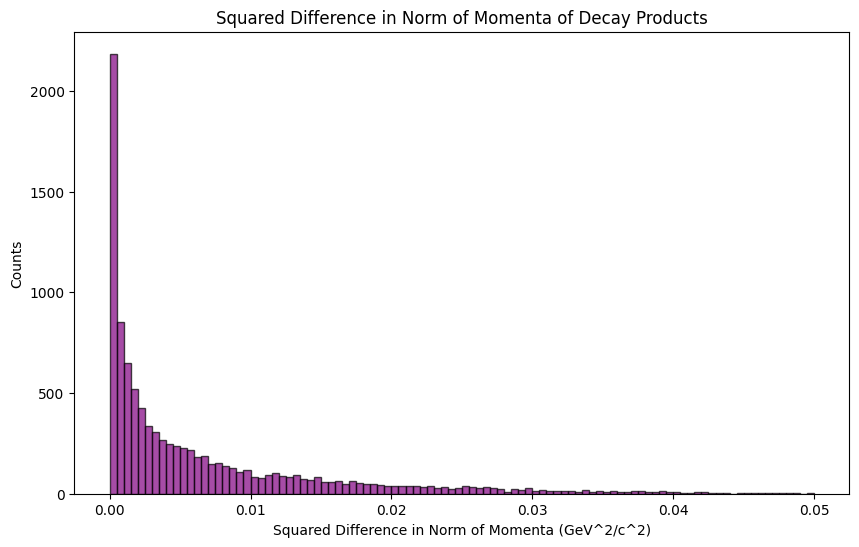

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_squared_momentum_diff(daughters_df):
    """
    Calculates and plots the distribution of the squared difference in norms of the momenta 
    of the two decay products (e+ and e-) in each event.
    
    Parameters:
    daughters_df (pd.DataFrame): DataFrame containing the daughter particle information with 
                                 columns ['Event Number', 'px', 'py', 'pz'].
    """
    # Calculate the norm of the momenta for each decay product
    daughters_df['momentum_norm'] = np.sqrt(daughters_df['px']**2 + daughters_df['py']**2 + daughters_df['pz']**2)
    
    # Group by event and get the norms for e+ and e- in each event
    momentum_norms = daughters_df.groupby('Event Number')['momentum_norm'].apply(list)
    
    # Calculate the squared difference in norms for each event
    squared_diff = [(norms[0] - norms[1])**2 for norms in momentum_norms if len(norms) == 2]
    
    # Plot the distribution with fixed binning
    plt.figure(figsize=(10, 6))
    plt.hist(squared_diff, bins=100, range=(-0.0, 0.05), color='purple', edgecolor='black', alpha=0.7)
    plt.title("Squared Difference in Norm of Momenta of Decay Products")
    plt.xlabel("Squared Difference in Norm of Momenta (GeV^2/c^2)")
    plt.ylabel("Counts")
    plt.show()

# Example usage:
plot_squared_momentum_diff(daughters_df)


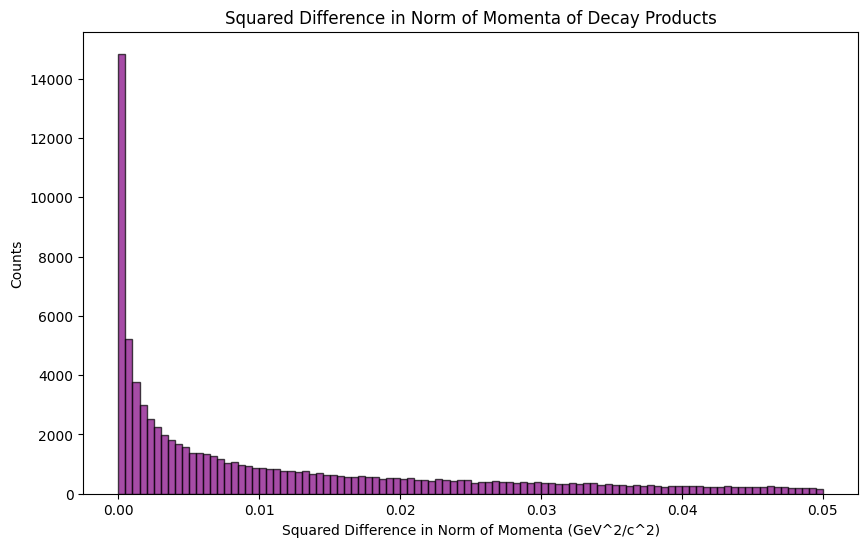

In [13]:
plot_squared_momentum_diff(daughters_gg_df)

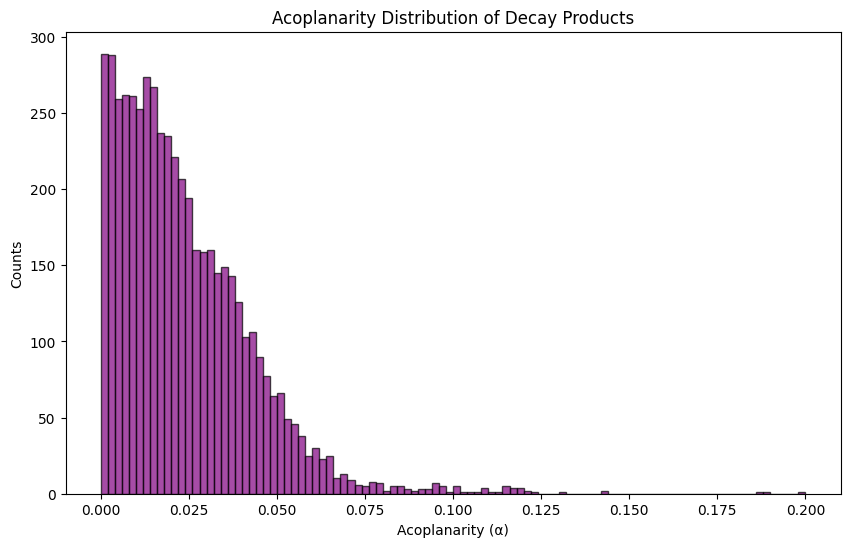

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_and_plot_acoplanarity(daughters_df):
    """
    Calculates and plots the acoplanarity (alpha) for a dataset of decay products.
    
    Parameters:
    daughters_df (pd.DataFrame): DataFrame containing the daughter particle information with 
                                 columns ['Event Number', 'px', 'py'].
    """
    # Calculate the azimuthal angle (phi) for each particle
    daughters_df['phi'] = np.arctan2(daughters_df['py'], daughters_df['px'])
    
    # Group by event and get the azimuthal angles for each event
    phi_angles = daughters_df.groupby('Event Number')['phi'].apply(list)
    
    # Calculate acoplanarity for each event
    acoplanarity = [1 - abs(phis[0] - phis[1]) / np.pi for phis in phi_angles if len(phis) == 2]
    
    # Plot the acoplanarity distribution
    plt.figure(figsize=(10, 6))
    plt.hist(acoplanarity, bins=100, range=(0, 0.2), color='purple', edgecolor='black', alpha=0.7)
    plt.title("Acoplanarity Distribution of Decay Products")
    plt.xlabel("Acoplanarity (α)")
    plt.ylabel("Counts")
    plt.show()

# Example usage:
calculate_and_plot_acoplanarity(daughters_df)


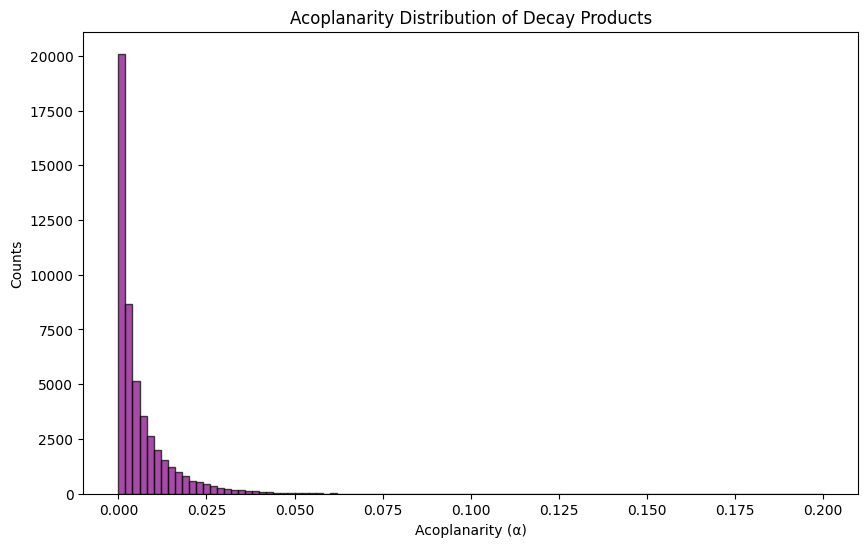

In [15]:
calculate_and_plot_acoplanarity(daughters_gg_df)


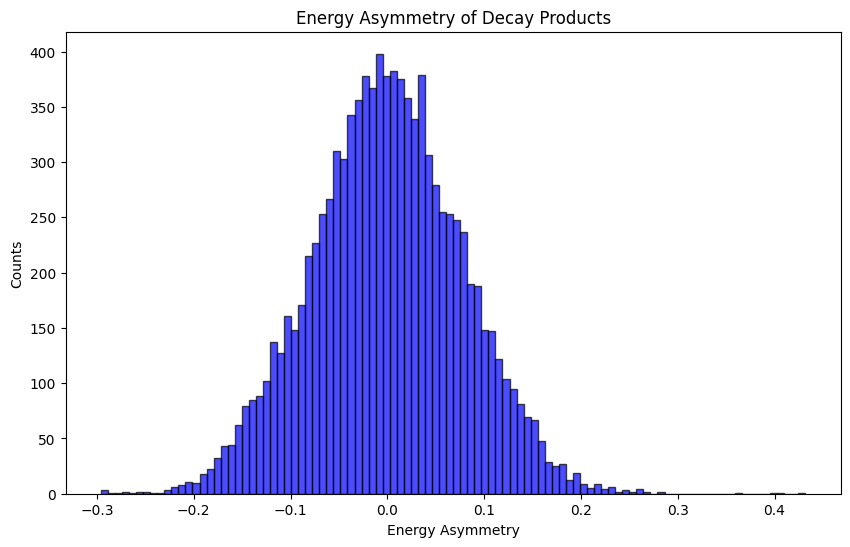

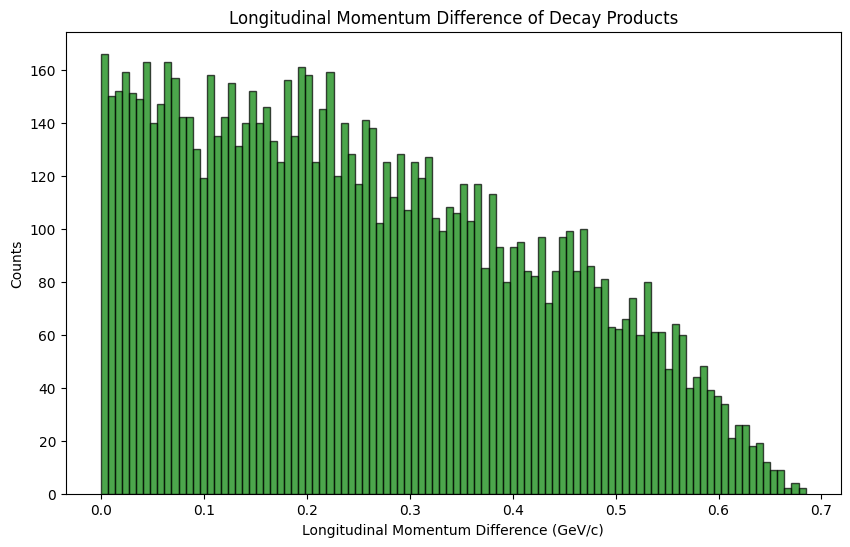

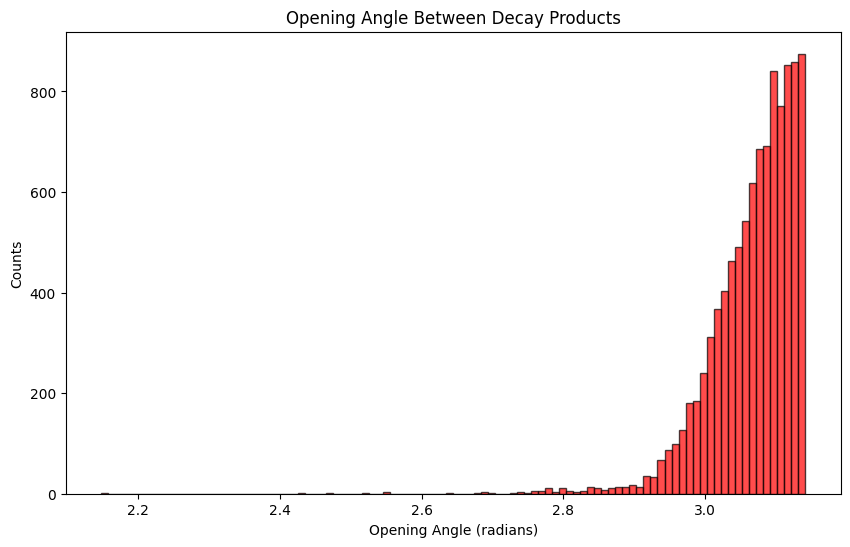

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_and_plot_additional_features(daughters_df):
    """
    Calculates and plots distributions for energy asymmetry, longitudinal momentum difference, 
    and opening angle between decay products.
    
    Parameters:
    daughters_df (pd.DataFrame): DataFrame containing the daughter particle information with 
                                 columns ['Event Number', 'Energy', 'px', 'py', 'pz'].
    """
    # Group by event and get the properties for each particle in each event
    grouped = daughters_df.groupby('Event Number')
    energies = grouped['Energy'].apply(list)
    pz_values = grouped['pz'].apply(list)
    px_values = grouped['px'].apply(list)
    py_values = grouped['py'].apply(list)
    
    # Calculate Energy Asymmetry for each event
    energy_asymmetry = [(e[0] - e[1]) / (e[0] + e[1]) for e in energies if len(e) == 2]
    
    # Calculate Longitudinal Momentum Difference for each event
    longitudinal_momentum_diff = [abs(pz[0] - pz[1]) for pz in pz_values if len(pz) == 2]
    
    # Calculate Opening Angle for each event
    opening_angles = []
    for px, py in zip(px_values, py_values):
        if len(px) == 2 and len(py) == 2:
            p1 = np.array([px[0], py[0]])
            p2 = np.array([px[1], py[1]])
            cos_theta = np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))
            opening_angles.append(np.arccos(cos_theta))

    # Plot Energy Asymmetry
    plt.figure(figsize=(10, 6))
    plt.hist(energy_asymmetry, bins=100, color='blue', edgecolor='black', alpha=0.7)
    plt.title("Energy Asymmetry of Decay Products")
    plt.xlabel("Energy Asymmetry")
    plt.ylabel("Counts")
    plt.show()
    
    # Plot Longitudinal Momentum Difference
    plt.figure(figsize=(10, 6))
    plt.hist(longitudinal_momentum_diff, bins=100, color='green', edgecolor='black', alpha=0.7)
    plt.title("Longitudinal Momentum Difference of Decay Products")
    plt.xlabel("Longitudinal Momentum Difference (GeV/c)")
    plt.ylabel("Counts")
    plt.show()

    # Plot Opening Angle
    plt.figure(figsize=(10, 6))
    plt.hist(opening_angles, bins=100, color='red', edgecolor='black', alpha=0.7)
    plt.title("Opening Angle Between Decay Products")
    plt.xlabel("Opening Angle (radians)")
    plt.ylabel("Counts")
    plt.show()

# Example usage:
calculate_and_plot_additional_features(daughters_df)


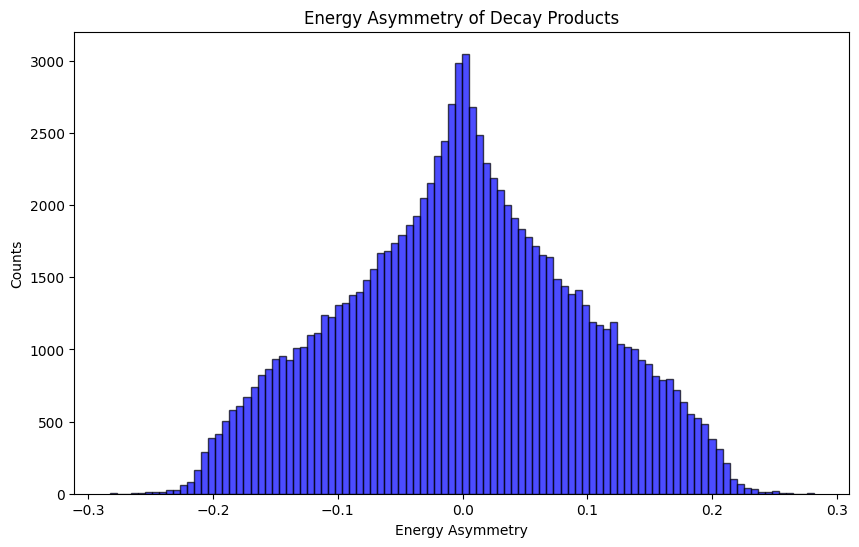

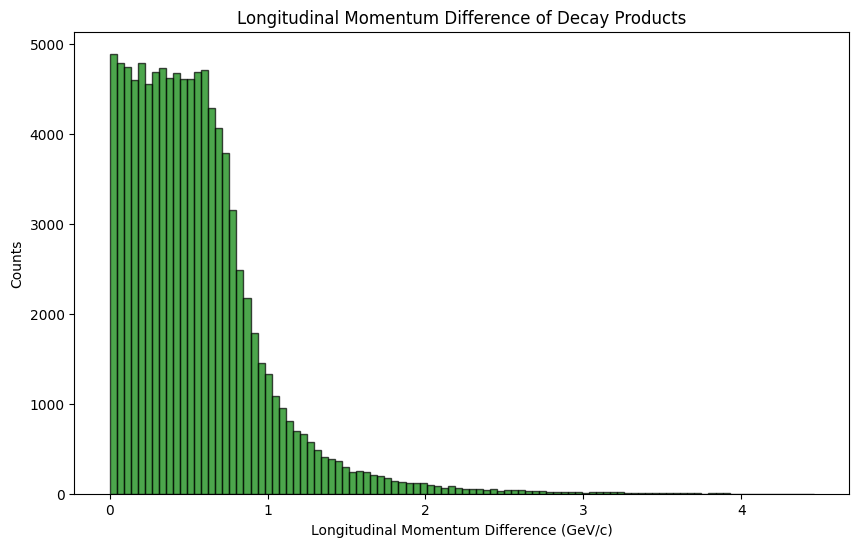

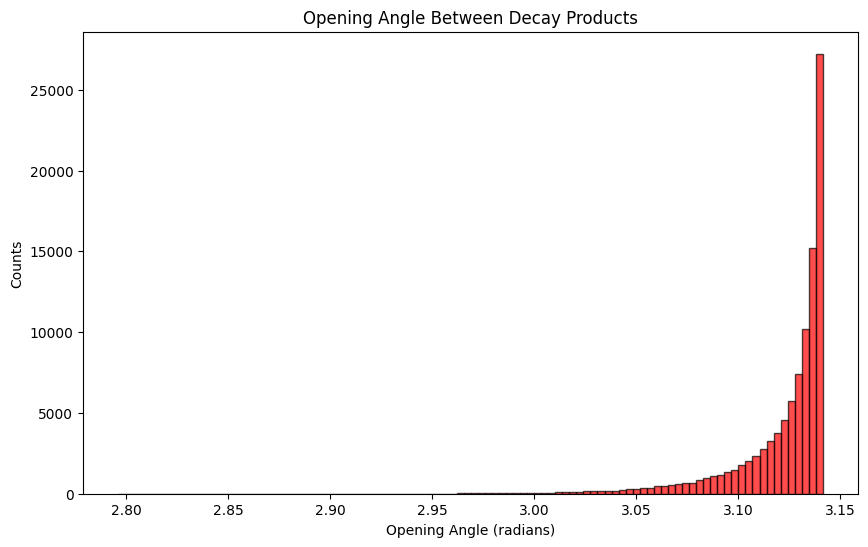

In [17]:
calculate_and_plot_additional_features(daughters_gg_df)


## Feature engineering

In [18]:
import numpy as np

def filter_by_acceptance(daughters_df):
    """
    Filters events based on acceptance criteria:
    - Each track must have pseudorapidity |eta| < 0.8
    - The mother particle (sum of two decay products) must have rapidity |y| < 0.8
    
    Parameters:
    daughters_df (pd.DataFrame): DataFrame containing the daughter particle information with 
                                 columns ['Event Number', 'px', 'py', 'pz', 'Energy'].
    
    Returns:
    pd.DataFrame: Filtered DataFrame with events that meet the acceptance criteria.
    """
    # Calculate pseudorapidity (eta) for each track
    daughters_df['eta'] = 0.5 * np.log((np.sqrt(daughters_df['px']**2 + daughters_df['py']**2 + daughters_df['pz']**2) + daughters_df['pz']) /
                                       (np.sqrt(daughters_df['px']**2 + daughters_df['py']**2 + daughters_df['pz']**2) - daughters_df['pz']))
    
    # Filter tracks based on |eta| < 0.8
    eta_filtered = daughters_df[np.abs(daughters_df['eta']) < 0.8]
    
    # Group by event and calculate the total four-momentum of the mother particle
    grouped = eta_filtered.groupby('Event Number')
    mother_px = grouped['px'].sum()
    mother_py = grouped['py'].sum()
    mother_pz = grouped['pz'].sum()
    mother_energy = grouped['Energy'].sum()
    
    # Calculate rapidity (y) of the mother particle
    mother_rapidity = 0.5 * np.log((mother_energy + mother_pz) / (mother_energy - mother_pz))
    
    # Filter events based on |y| < 0.8 for the mother particle
    accepted_events = mother_rapidity[np.abs(mother_rapidity) < 0.8].index
    filtered_daughters_df = eta_filtered[eta_filtered['Event Number'].isin(accepted_events)]
    
    return filtered_daughters_df

# Example usage:
filtered_daughters_df = filter_by_acceptance(daughters_df)
filtered_daughters_gg_df = filter_by_acceptance(daughters_gg_df)


In [19]:
def compute_features(daughters_df):
    """
    Computes a set of features from the input filtered DataFrame, including:
    - Invariant mass of the e+e- pair
    - Transverse momentum (pT) of the e+e- pair
    - Squared difference in norms of momenta
    - Acoplanarity
    - Energy asymmetry
    - Longitudinal momentum difference
    - Opening angle between decay products
    
    Parameters:
    daughters_df (pd.DataFrame): Filtered DataFrame containing daughter particle information with 
                                 columns ['Event Number', 'px', 'py', 'pz', 'Energy'].
    
    Returns:
    pd.DataFrame: DataFrame containing computed features for each event.
    """
    # Group by event to compute pair-level features
    grouped = daughters_df.groupby('Event Number')
    
    # Initialize lists to collect computed features
    event_numbers = []
    invariant_masses = []
    pt_ee_pairs = []
    squared_momentum_diffs = []
    acoplanarities = []
    energy_asymmetries = []
    longitudinal_momentum_diffs = []
    opening_angles = []
    
    # Loop over each event
    for event_num, group in grouped:
        if len(group) != 2:
            continue  # Only process events with exactly two tracks

        # Extract track-level variables
        px1, py1, pz1, E1 = group.iloc[0][['px', 'py', 'pz', 'Energy']]
        px2, py2, pz2, E2 = group.iloc[1][['px', 'py', 'pz', 'Energy']]
        
        # Event-level variables
        event_numbers.append(event_num)
        
        # 1. Invariant mass of the e+e- pair
        total_energy = E1 + E2
        total_px = px1 + px2
        total_py = py1 + py2
        total_pz = pz1 + pz2
        invariant_mass = np.sqrt(total_energy**2 - total_px**2 - total_py**2 - total_pz**2)
        invariant_masses.append(invariant_mass)
        
        # 2. Transverse momentum (pT) of the e+e- pair
        pt_ee_pairs.append(np.sqrt(total_px**2 + total_py**2))
        
        # 3. Squared difference in norms of momenta
        norm1 = np.sqrt(px1**2 + py1**2 + pz1**2)
        norm2 = np.sqrt(px2**2 + py2**2 + pz2**2)
        squared_momentum_diffs.append((norm1 - norm2)**2)
        
        # 4. Acoplanarity
        phi1 = np.arctan2(py1, px1)
        phi2 = np.arctan2(py2, px2)
        phi_diff = abs(phi1 - phi2)
        phi_diff = min(phi_diff, 2 * np.pi - phi_diff)  # Ensure difference is within [0, π]
        acoplanarity = 1 - phi_diff / np.pi
        acoplanarities.append(acoplanarity)
        
        # 5. Energy asymmetry
        energy_asymmetry = (E1 - E2) / (E1 + E2)
        energy_asymmetries.append(energy_asymmetry)
        
        # 6. Longitudinal momentum difference
        longitudinal_momentum_diffs.append(abs(pz1 - pz2))
        
        # 7. Opening angle between decay products
        p1 = np.array([px1, py1, pz1])
        p2 = np.array([px2, py2, pz2])
        cos_theta = np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))
        opening_angle = np.arccos(cos_theta)
        opening_angles.append(opening_angle)

    # Construct DataFrame with all computed features
    features_df = pd.DataFrame({
        'Event Number': event_numbers,
        'Invariant Mass': invariant_masses,
        'pT (e+e-)': pt_ee_pairs,
        'Squared Momentum Difference': squared_momentum_diffs,
        'Acoplanarity': acoplanarities,
        'Energy Asymmetry': energy_asymmetries,
        'Longitudinal Momentum Difference': longitudinal_momentum_diffs,
        'Opening Angle': opening_angles
    })
    
    return features_df

# filtered_daughters_df = filter_by_acceptance(daughters_df)
features_df = compute_features(filtered_daughters_df)
features_gg_df = compute_features(filtered_daughters_gg_df)


In [20]:
features_df.head()

,Event Number,Invariant Mass,pT (e+e-),Squared Momentum Difference,Acoplanarity,Energy Asymmetry,Longitudinal Momentum Difference,Opening Angle
0,1,1.019105,0.049644,0.001367,0.031132,0.033901,0.108016,2.416859
1,2,1.026712,0.035786,0.000114,0.015473,-0.010213,0.190259,2.756913
2,3,1.022900,0.026768,0.002767,0.009099,0.050971,0.555489,2.895069
3,4,1.022102,0.048372,0.003278,0.021657,-0.050388,0.201350,2.242625
4,5,1.019904,0.070026,0.018480,0.043915,-0.129193,0.464285,2.716208


In [21]:
features_gg_df.head()

,Event Number,Invariant Mass,pT (e+e-),Squared Momentum Difference,Acoplanarity,Energy Asymmetry,Longitudinal Momentum Difference,Opening Angle
0,2,1.005036,0.076434,0.001046,0.043453,0.031978,0.012714,2.926895
1,3,1.634441,0.045710,0.000424,0.009416,0.012576,0.899046,3.009829
2,4,2.696346,0.049396,0.000018,0.008649,0.001532,0.123991,2.683888
3,5,1.386350,0.017144,0.020675,0.001141,0.098929,0.427441,2.563553
4,7,1.108427,0.016459,0.000012,0.008464,-0.003088,0.092793,3.051142


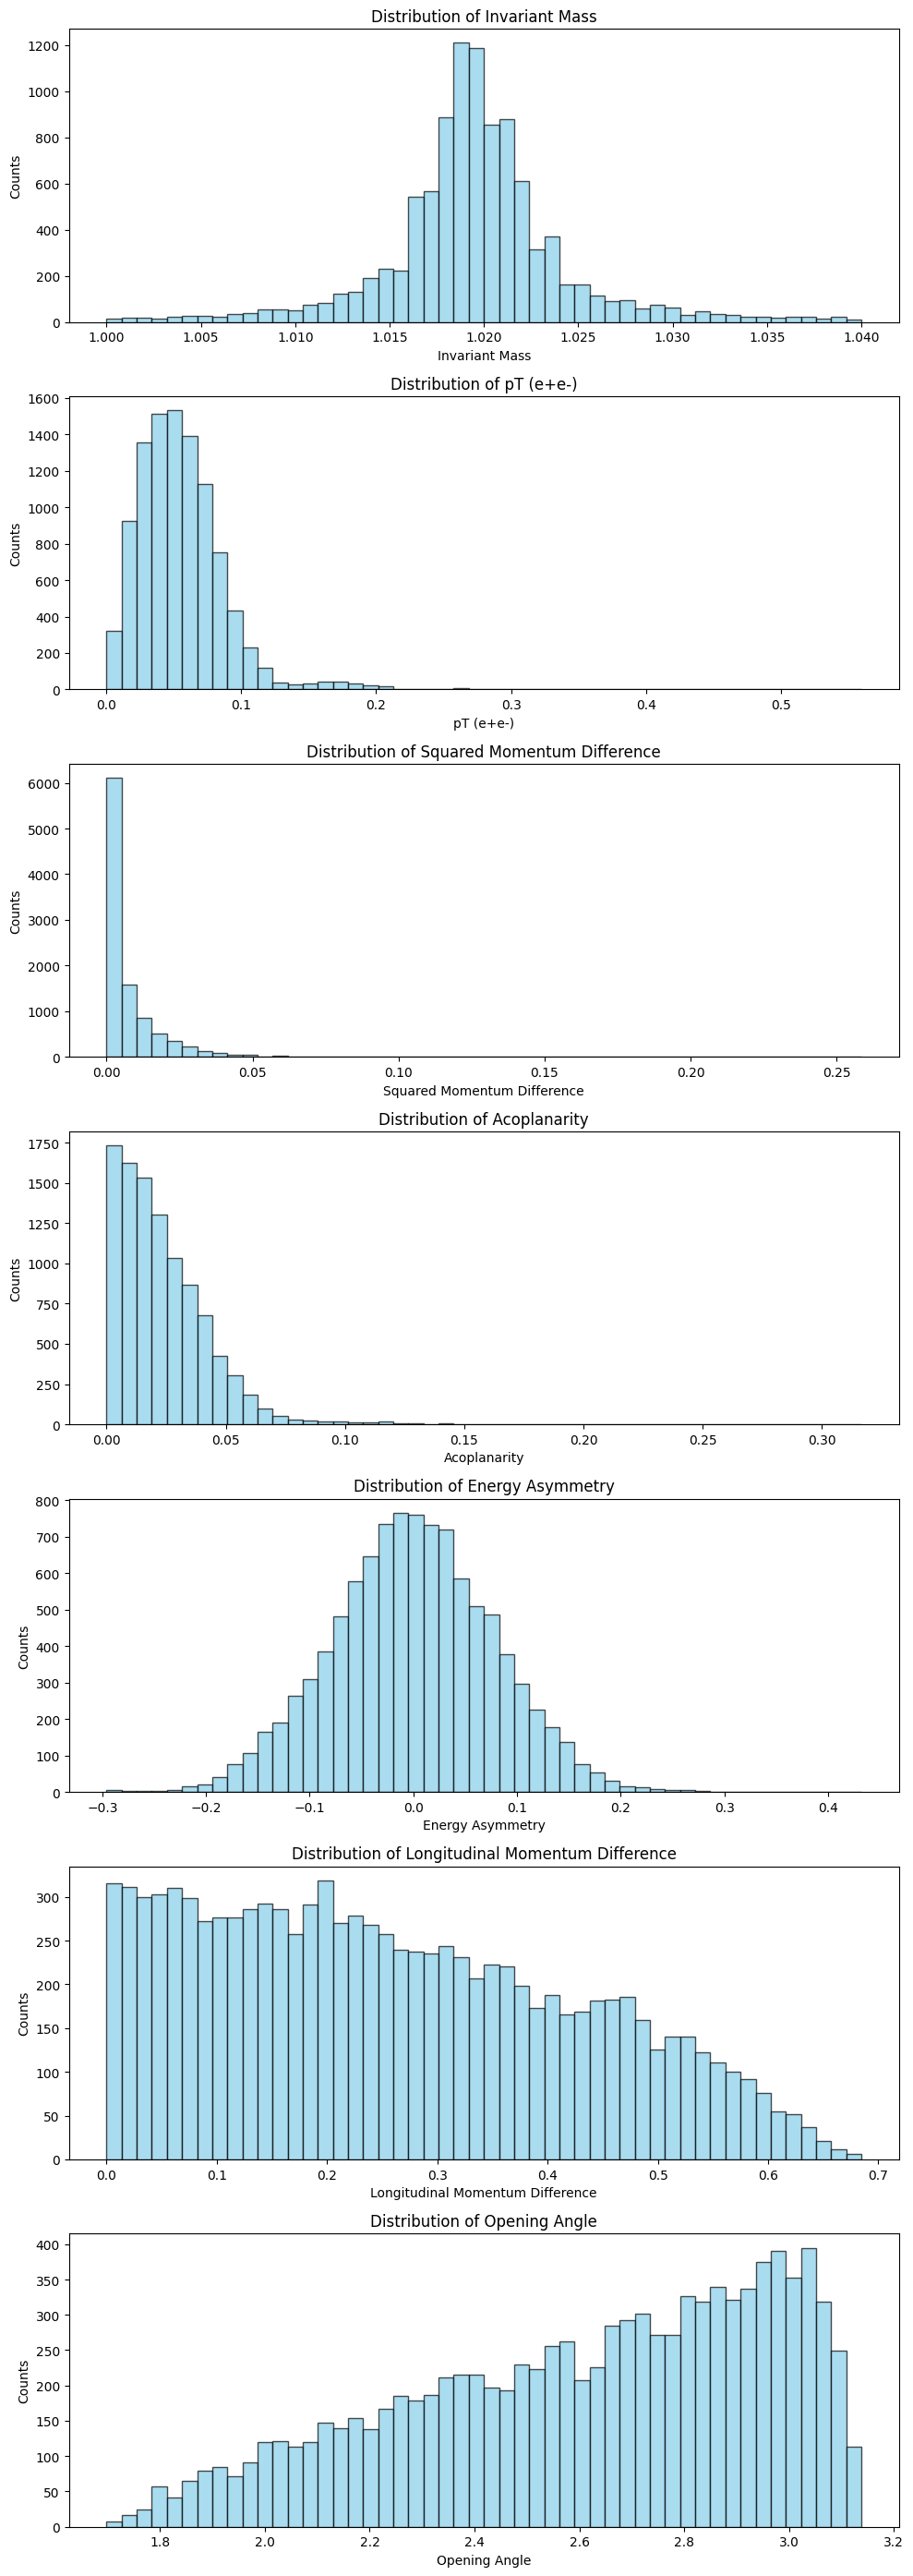

In [22]:
import matplotlib.pyplot as plt

def plot_features(features_df):
    """
    Plots histograms for each feature in the features DataFrame.
    
    Parameters:
    features_df (pd.DataFrame): DataFrame containing computed features for each event.
    """
    # Set up a figure with subplots for each feature
    n_features = features_df.shape[1] - 1  # Exclude the 'Event Number' column
    fig, axs = plt.subplots(n_features, 1, figsize=(10, 4 * n_features))
    
    # Plot each feature in a separate subplot
    for i, col in enumerate(features_df.columns[1:]):  # Skip 'Event Number' column
        axs[i].hist(features_df[col], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
        axs[i].set_title(f"Distribution of {col}")
        axs[i].set_xlabel(col)
        axs[i].set_ylabel("Counts")
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_features(features_df)


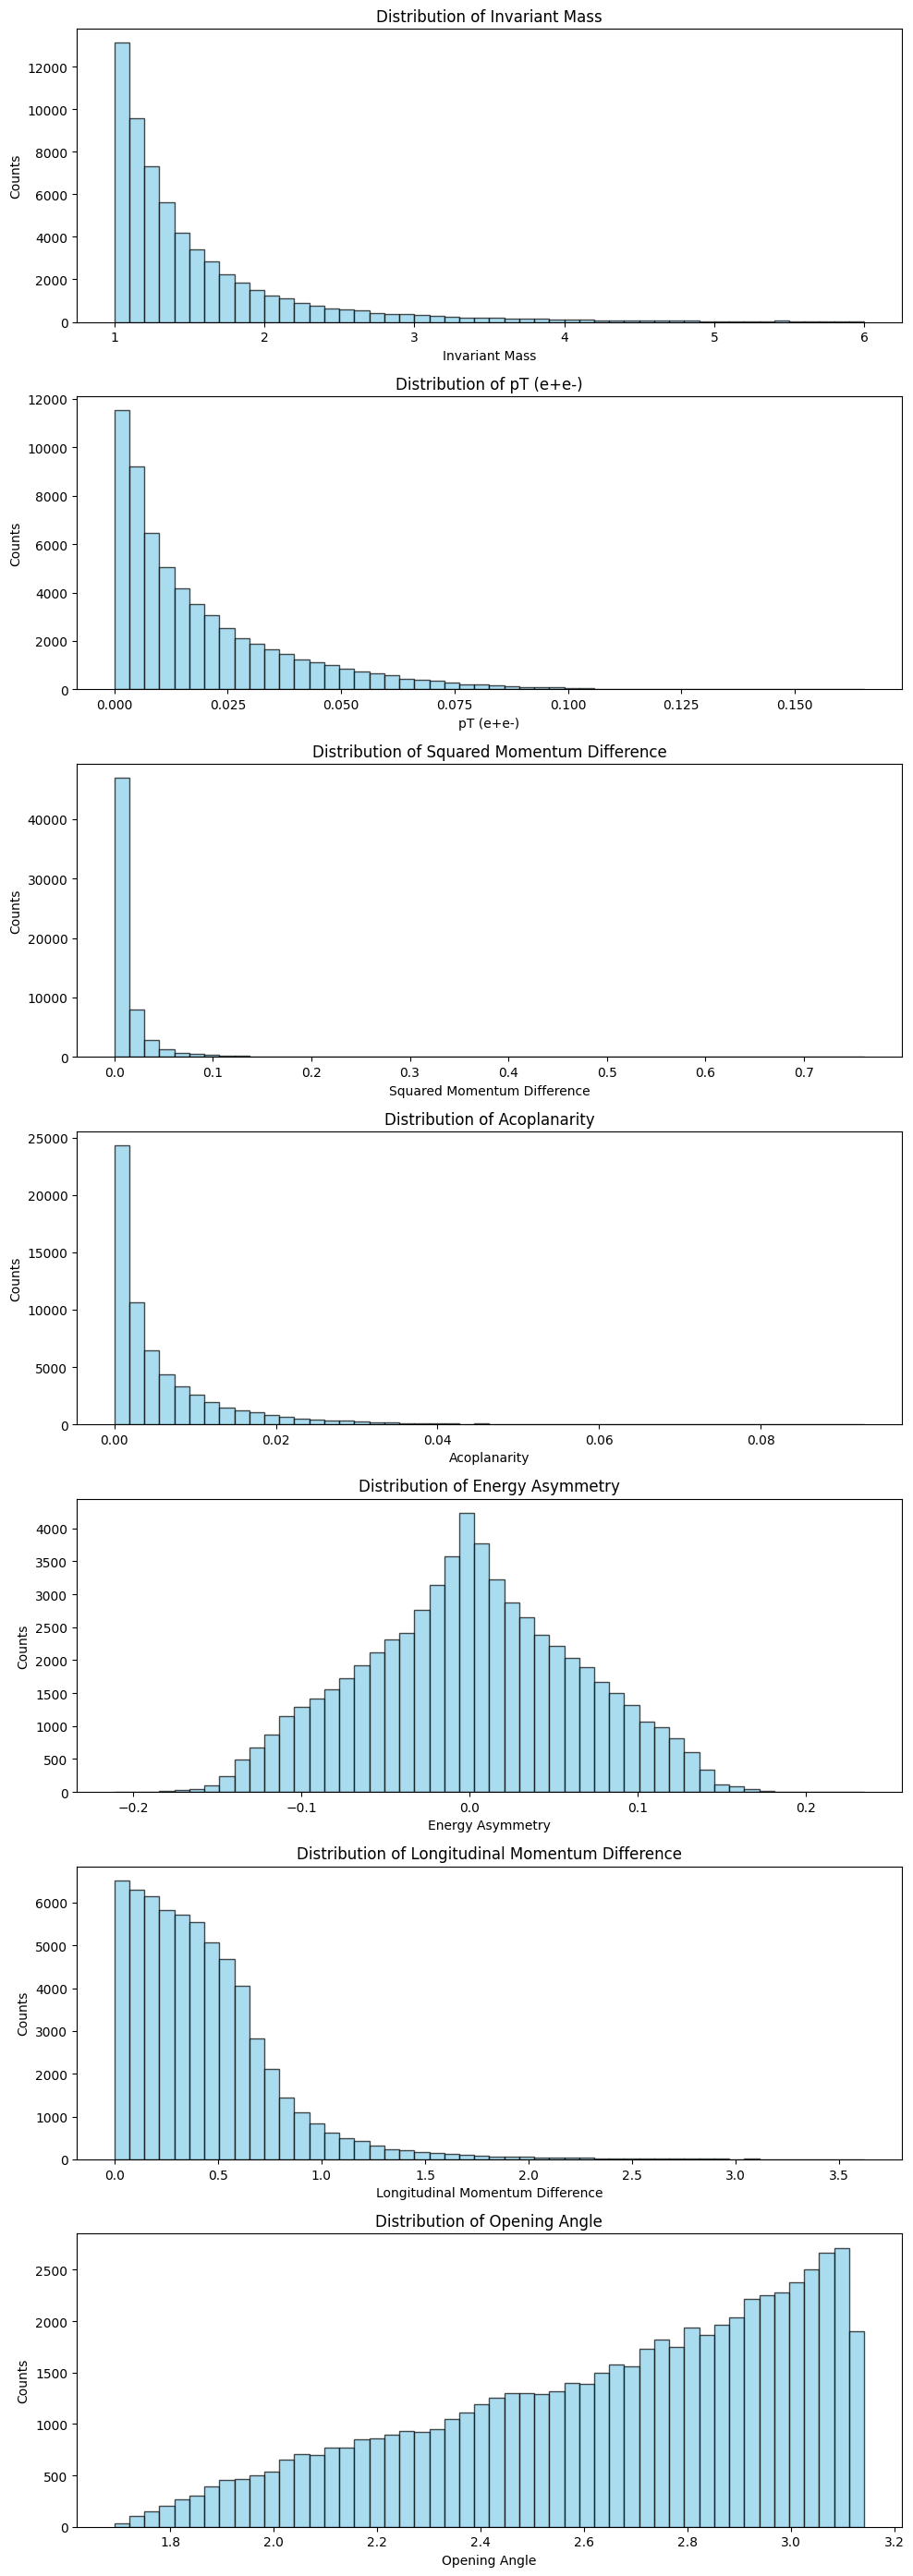

In [23]:
plot_features(features_gg_df)


### Random forest

In [24]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

def prepare_data(phi_features_df, photon_features_df):
    """
    Prepares the combined dataset with labels.
    - phi_features_df: DataFrame with features for phi -> e+ e- events (signal, label 1)
    - photon_features_df: DataFrame with features for photon-photon -> e+ e- events (background, label 0)
    
    Returns:
    X, y: Feature matrix and labels
    """
    # Assign labels
    phi_features_df['Label'] = 1  # Signal
    photon_features_df['Label'] = 0  # Background
    
    # Combine datasets
    combined_df = pd.concat([phi_features_df, photon_features_df], ignore_index=True)
    
    # Separate features and labels
    X = combined_df.drop(columns=['Event Number', 'Label'])  # Drop non-feature columns
    y = combined_df['Label']
    
    return X, y

def train_random_forest(X, y):
    """
    Trains a Random Forest classifier on the given data and evaluates its performance.
    
    Parameters:
    X (pd.DataFrame): Feature matrix
    y (pd.Series): Labels
    
    Returns:
    model: Trained Random Forest model
    """
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Initialize the Random Forest classifier
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    # rf_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
    
    # Train the model
    rf_model.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
    
    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"Accuracy: {accuracy:.3f}")
    print(f"ROC-AUC: {roc_auc:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Feature importance
    feature_importances = rf_model.feature_importances_
    feature_names = X.columns
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, feature_importances, color='skyblue')
    plt.title("Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()
    
    return rf_model

# Example usage:
X, y = prepare_data(features_df, features_gg_df)
# rf_model = train_random_forest(X, y)


### Now selecting only the right invariant mass region

In [25]:
def prepare_filter_mass_range_data(phi_features_df, photon_features_df, mass_min=1.0, mass_max=1.04):
    """
    Prepares the combined dataset with labels.
    - phi_features_df: DataFrame with features for phi -> e+ e- events (signal, label 1)
    - photon_features_df: DataFrame with features for photon-photon -> e+ e- events (background, label 0)
    
    Returns:
    X, y: Feature matrix and labels
    """
    # Assign labels
    phi_features_df['Label'] = 1  # Signal
    photon_features_df['Label'] = 0  # Background
    
    # Combine datasets
    filtered_df = photon_features_df[(photon_features_df['Invariant Mass'] >= mass_min) & (photon_features_df['Invariant Mass'] <= mass_max)]
    combined_df = pd.concat([phi_features_df, filtered_df], ignore_index=True)
    
    # Separate features and labels
    X = combined_df.drop(columns=['Event Number', 'Invariant Mass', 'Label'])  # Drop non-feature columns
    y = combined_df['Label']
    
    return X, y

X_filtered, y_filtered = prepare_filter_mass_range_data(features_df, features_gg_df)
# rf_model_filtered = train_random_forest(X_filtered, y_filtered)

In [26]:
X_filtered.head()

,pT (e+e-),Squared Momentum Difference,Acoplanarity,Energy Asymmetry,Longitudinal Momentum Difference,Opening Angle
0,0.049644,0.001367,0.031132,0.033901,0.108016,2.416859
1,0.035786,0.000114,0.015473,-0.010213,0.190259,2.756913
2,0.026768,0.002767,0.009099,0.050971,0.555489,2.895069
3,0.048372,0.003278,0.021657,-0.050388,0.201350,2.242625
4,0.070026,0.018480,0.043915,-0.129193,0.464285,2.716208


Accuracy: 0.813
ROC-AUC: 0.860

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.67      0.72      1715
           1       0.83      0.89      0.86      3023

    accuracy                           0.81      4738
   macro avg       0.80      0.78      0.79      4738
weighted avg       0.81      0.81      0.81      4738



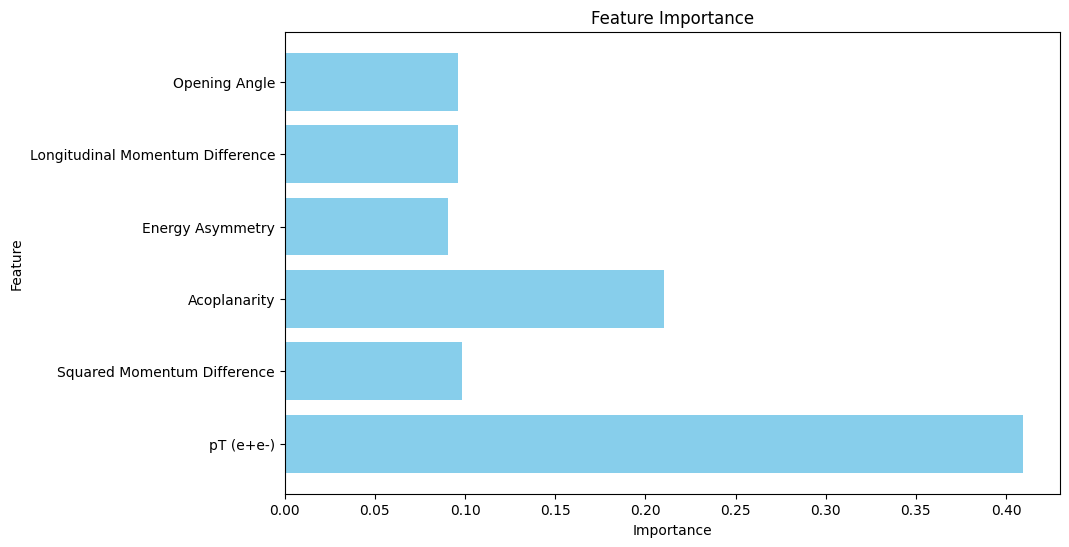

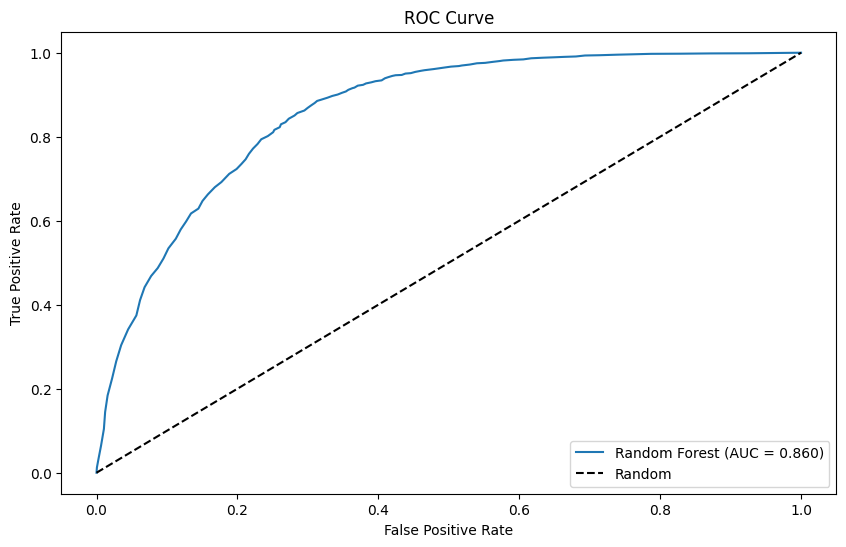

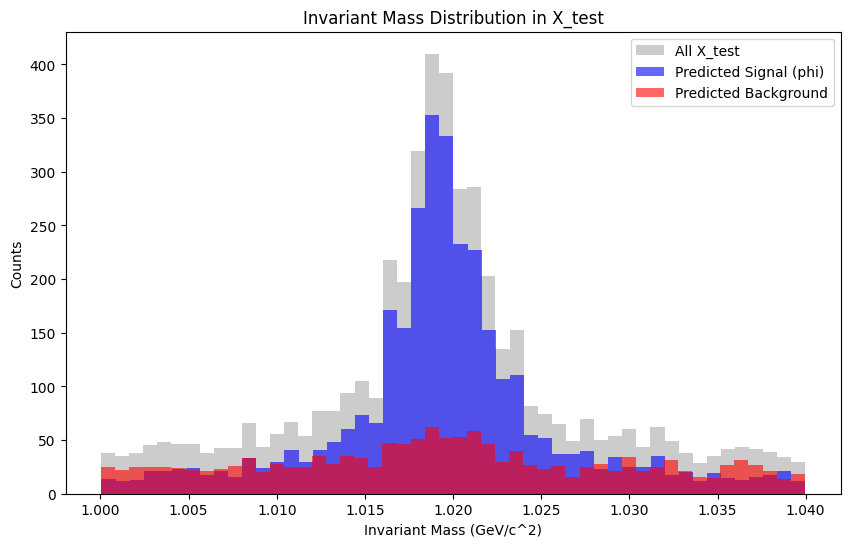

In [27]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve
import matplotlib.pyplot as plt

def prepare_filter_mass_range_data(phi_features_df, photon_features_df, mass_min=1.0, mass_max=1.04):
    """
    Prepares the combined dataset with labels.
    - phi_features_df: DataFrame with features for phi -> e+ e- events (signal, label 1)
    - photon_features_df: DataFrame with features for photon-photon -> e+ e- events (background, label 0)
    
    Returns:
    X, y: Feature matrix and labels
    """
    # Assign labels
    phi_features_df['Label'] = 1  # Signal
    photon_features_df['Label'] = 0  # Background
    
    # Filter photon background by invariant mass range
    filtered_df = photon_features_df[(photon_features_df['Invariant Mass'] >= mass_min) & (photon_features_df['Invariant Mass'] <= mass_max)]
    
    # Combine datasets
    combined_df = pd.concat([phi_features_df, filtered_df], ignore_index=True)
    
    # Separate features and labels
    X = combined_df.drop(columns=['Event Number', 'Label'])  # Drop non-feature columns but keep 'Invariant Mass' for plotting
    y = combined_df['Label']
    
    return X, y

def train_random_forest(phi_features_df, photon_features_df, mass_min=1.0, mass_max=1.04):
    """
    Trains a Random Forest classifier on the given data and evaluates its performance.
    
    Parameters:
    phi_features_df (pd.DataFrame): DataFrame with features for phi -> e+ e- events (signal, label 1)
    photon_features_df (pd.DataFrame): DataFrame with features for photon-photon -> e+ e- events (background, label 0)
    mass_min (float): Minimum invariant mass for filtering background events
    mass_max (float): Maximum invariant mass for filtering background events
    
    Returns:
    model: Trained Random Forest model
    """
    # Prepare data with filtering
    X, y = prepare_filter_mass_range_data(phi_features_df, photon_features_df, mass_min, mass_max)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=['Invariant Mass']), y, test_size=0.3, random_state=42)
    
    # Initialize the Random Forest classifier
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    # rf_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
    
    # Train the model
    rf_model.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
    
    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"Accuracy: {accuracy:.3f}")
    print(f"ROC-AUC: {roc_auc:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Feature importance
    feature_importances = rf_model.feature_importances_
    feature_names = X_train.columns
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, feature_importances, color='skyblue')
    plt.title("Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

    # Plot invariant mass distributions
    fig, ax = plt.subplots(figsize=(10, 6))

    # Overall invariant mass distribution in X_test
    invariant_mass_test = X_test.join(X[['Invariant Mass']])
    ax.hist(invariant_mass_test['Invariant Mass'], bins=50, color='gray', alpha=0.4, label='All X_test')

    # Signal (phi) invariant mass distribution in X_test
    signal_mask = (y_pred == 1)  # Assuming label 1 is for the phi signal
    ax.hist(invariant_mass_test[signal_mask]['Invariant Mass'], bins=50, color='blue', alpha=0.6, label='Predicted Signal (phi)')

    # Background invariant mass distribution in X_test
    background_mask = (y_pred == 0)  # Assuming label 0 is for the background
    ax.hist(invariant_mass_test[background_mask]['Invariant Mass'], bins=50, color='red', alpha=0.6, label='Predicted Background')

    # Labels and legend
    ax.set_title("Invariant Mass Distribution in X_test")
    ax.set_xlabel("Invariant Mass (GeV/c^2)")
    ax.set_ylabel("Counts")
    ax.legend(loc="upper right")

    plt.show()
    
    return rf_model

# Example usage:
rf_model_filtered = train_random_forest(features_df, features_gg_df)


Accuracy: 0.813
ROC-AUC: 0.860

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.67      0.72      1715
           1       0.83      0.89      0.86      3023

    accuracy                           0.81      4738
   macro avg       0.80      0.78      0.79      4738
weighted avg       0.81      0.81      0.81      4738



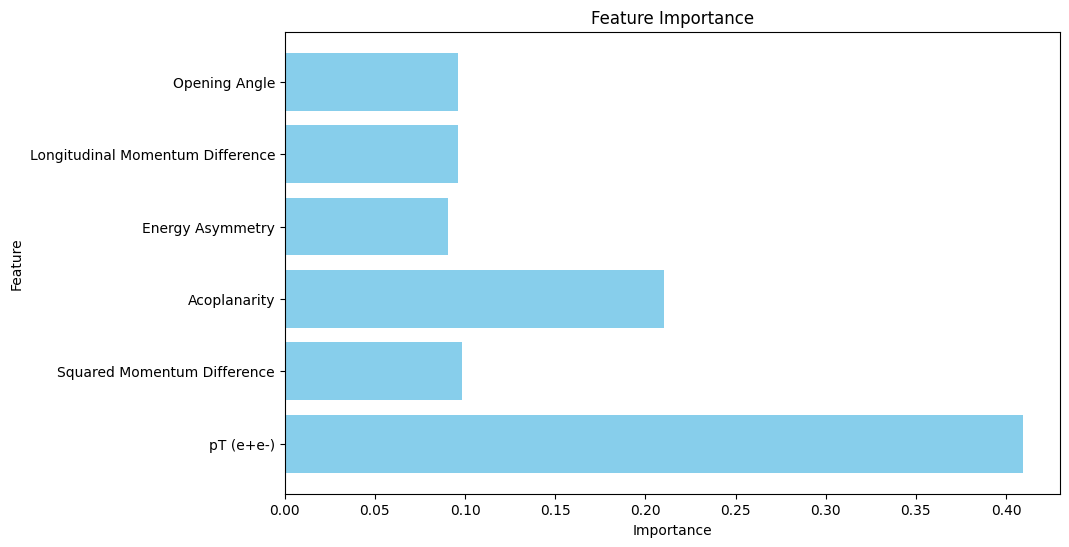

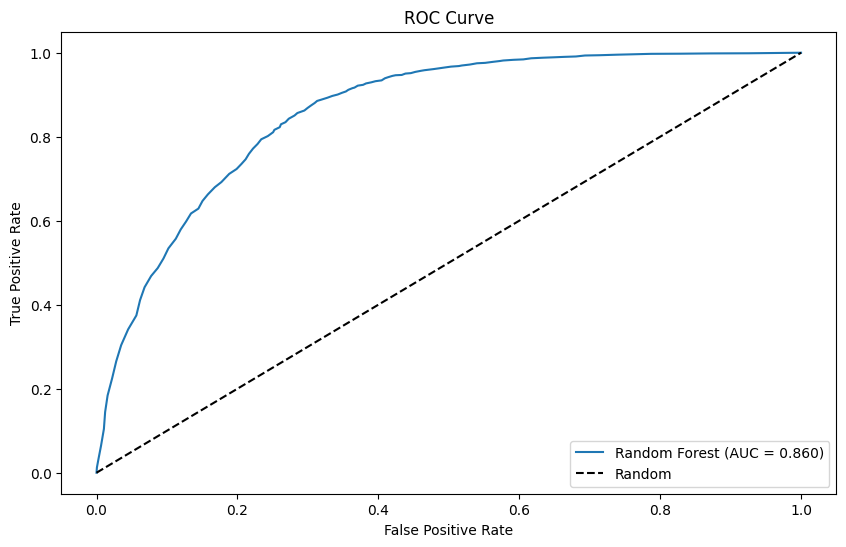

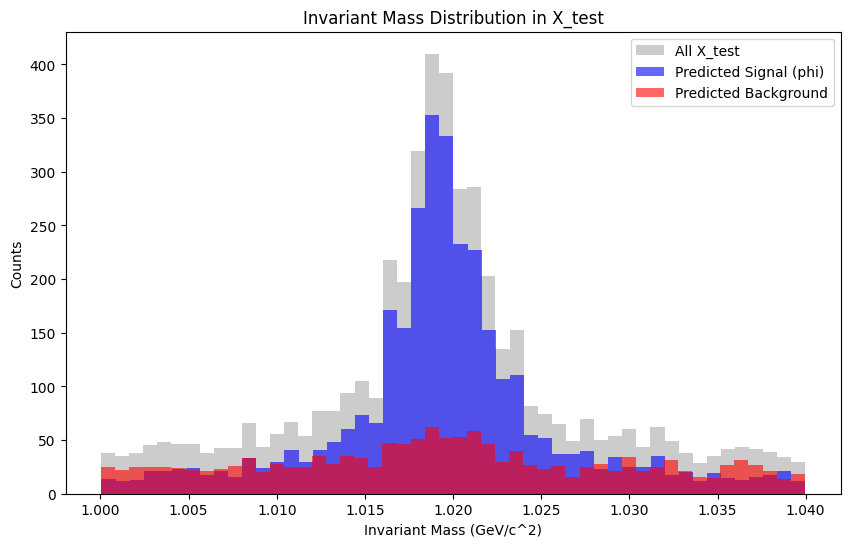

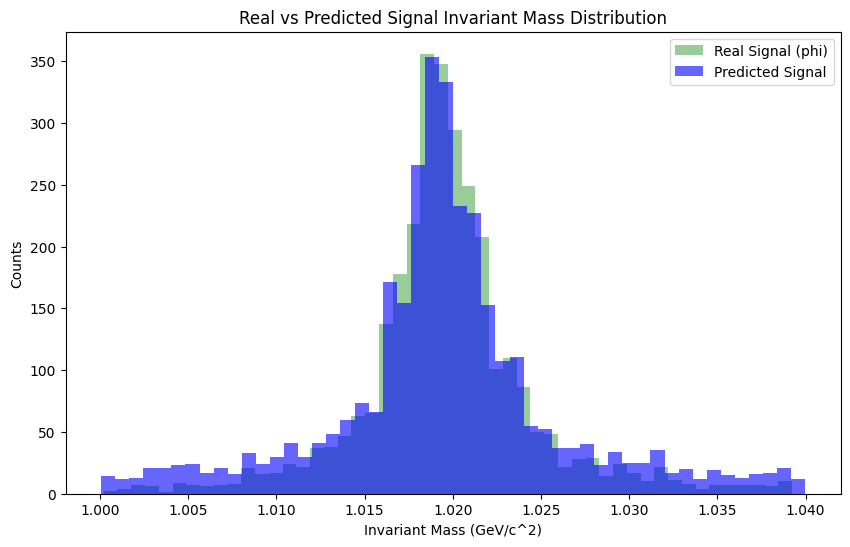

In [28]:
from catboost import CatBoostClassifier

def train_random_forest(phi_features_df, photon_features_df, mass_min=1.0, mass_max=1.04):
    """
    Trains a Random Forest classifier on the given data and evaluates its performance.
    
    Parameters:
    phi_features_df (pd.DataFrame): DataFrame with features for phi -> e+ e- events (signal, label 1)
    photon_features_df (pd.DataFrame): DataFrame with features for photon-photon -> e+ e- events (background, label 0)
    mass_min (float): Minimum invariant mass for filtering background events
    mass_max (float): Maximum invariant mass for filtering background events
    
    Returns:
    model: Trained Random Forest model
    """
    # Prepare data with filtering
    X, y = prepare_filter_mass_range_data(phi_features_df, photon_features_df, mass_min, mass_max)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=['Invariant Mass']), y, test_size=0.3, random_state=42)
    
    # Initialize the Random Forest classifier
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    # rf_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
    # rf_model = CatBoostClassifier(iterations=100, verbose=0, random_state=42)

    # Train the model
    rf_model.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
    
    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"Accuracy: {accuracy:.3f}")
    print(f"ROC-AUC: {roc_auc:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Feature importance
    feature_importances = rf_model.feature_importances_
    feature_names = X_train.columns
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, feature_importances, color='skyblue')
    plt.title("Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.savefig("features.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.savefig("roc.pdf", format="pdf", bbox_inches="tight")
    plt.show()

    # Plot invariant mass distributions
    fig, ax = plt.subplots(figsize=(10, 6))

    # Overall invariant mass distribution in X_test
    invariant_mass_test = X_test.join(X[['Invariant Mass']])
    ax.hist(invariant_mass_test['Invariant Mass'], bins=50, color='gray', alpha=0.4, label='All X_test')

    # Signal (phi) invariant mass distribution in X_test
    signal_mask = (y_pred == 1)  # Assuming label 1 is for the phi signal
    ax.hist(invariant_mass_test[signal_mask]['Invariant Mass'], bins=50, color='blue', alpha=0.6, label='Predicted Signal (phi)')

    # Background invariant mass distribution in X_test
    background_mask = (y_pred == 0)  # Assuming label 0 is for the background
    ax.hist(invariant_mass_test[background_mask]['Invariant Mass'], bins=50, color='red', alpha=0.6, label='Predicted Background')

    # Labels and legend
    ax.set_title("Invariant Mass Distribution in X_test")
    ax.set_xlabel("Invariant Mass (GeV/c^2)")
    ax.set_ylabel("Counts")
    ax.legend(loc="upper right")

    plt.savefig("inv-mass.pdf", format="pdf", bbox_inches="tight")
    plt.show()

    # Additional plot: Real vs Predicted Signal
    fig, ax = plt.subplots(figsize=(10, 6))

    # Real signal events (true phi events)
    real_signal_mask = (y_test == 1)
    ax.hist(invariant_mass_test[real_signal_mask]['Invariant Mass'], bins=50, color='green', alpha=0.4, label='Real Signal (phi)')

    # Predicted signal events (events classified as signal by model)
    predicted_signal_mask = (y_pred == 1)
    ax.hist(invariant_mass_test[predicted_signal_mask]['Invariant Mass'], bins=50, color='blue', alpha=0.6, label='Predicted Signal')

    # Labels and legend
    ax.set_title("Real vs Predicted Signal Invariant Mass Distribution")
    ax.set_xlabel("Invariant Mass (GeV/c^2)")
    ax.set_ylabel("Counts")
    ax.legend(loc="upper right")

    plt.show()
    
    return rf_model

# Example usage:
rf_model_filtered = train_random_forest(features_df, features_gg_df)


## Using ALICE data 

Keys in the ROOT file: ['DF_2336518081368096;1', 'DF_2336518081368096/O2tree;1']
Branches in the tree: ['fPX1', 'fPY1', 'fPZ1', 'fPE1', 'fPX2', 'fPY2', 'fPZ2', 'fPE2', 'fNCOUNTERPV', 'fNELECTRONSTOF']
       fPX1      fPY1      fPZ1      fPE1      fPX2      fPY2      fPZ2  \
0  0.380054 -0.298258  0.218900  0.530393 -0.394773  0.303569 -0.138682   
1 -0.006880  0.306499 -0.018638  0.307143  0.006890 -0.327766 -0.282457   
2 -0.074406 -0.541143 -0.165148  0.570654  0.046732  0.467763  0.282230   
3 -0.490760 -0.127637 -0.275347  0.577020  0.477005  0.131425 -0.227821   
4  0.031068  0.373844 -0.298184  0.479206 -0.021104 -0.371243  0.111860   

       fPE2  fNCOUNTERPV  fNELECTRONSTOF  
0  0.516946            2               0  
1  0.432736            2               0  
2  0.548307            2               1  
3  0.544710            2               0  
4  0.388304            2               0  

DataFrame for fNELECTRONSTOF = 0:
       fPX1      fPY1      fPZ1      fPE1      fPX2    

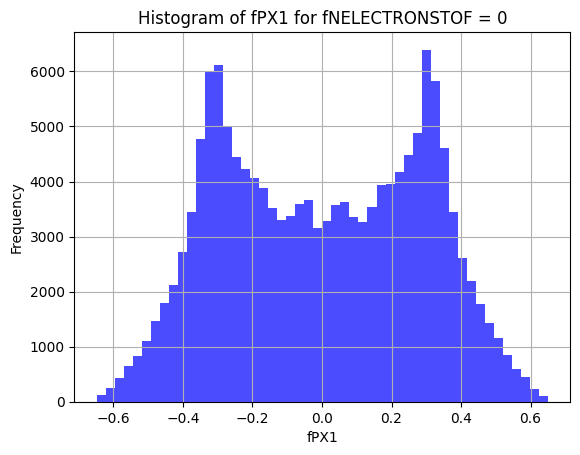

In [29]:
import uproot
import pandas as pd
import matplotlib.pyplot as plt

# Path to the ROOT file
root_file_path = "AO2D.root"

# Open the ROOT file
file = uproot.open(root_file_path)

# List all the keys (trees, histograms, etc.) in the file
print("Keys in the ROOT file:", file.keys())

# Access a specific tree by its name
tree_name = "DF_2336518081368096/O2tree"  # Replace with your tree name
tree = file[tree_name]

# Print the list of branches in the tree
print("Branches in the tree:", tree.keys())

# Convert the tree into a Pandas DataFrame for easy manipulation
branches_to_load = [
    "fPX1", "fPY1", "fPZ1", "fPE1",
    "fPX2", "fPY2", "fPZ2", "fPE2",
    "fNCOUNTERPV", "fNELECTRONSTOF"
]
df = tree.arrays(branches_to_load, library="pd")

# Display the first few rows of the DataFrame
print(df.head())

# Split the DataFrame into three based on the value of fNELECTRONSTOF
df_original = {}
for tof_value in [0, 1, 2]:
    df_subset = df[df["fNELECTRONSTOF"] == tof_value].copy()
    df_subset.drop(columns=["fNELECTRONSTOF"], inplace=True)  # Remove fNELECTRONSTOF column
    df_original[tof_value] = df_subset

# Verify the resulting DataFrames
for tof_value, subset_df in df_original.items():
    print(f"\nDataFrame for fNELECTRONSTOF = {tof_value}:")
    print(subset_df.head())

# Example: Plot a histogram of fPX1 for fNELECTRONSTOF = 0
branch_to_plot = "fPX1"
plt.hist(df_original[0][branch_to_plot], bins=50, color="blue", alpha=0.7)
plt.xlabel(branch_to_plot)
plt.ylabel("Frequency")
plt.title(f"Histogram of {branch_to_plot} for fNELECTRONSTOF = 0")
plt.grid(True)
plt.show()


In [30]:
df.head()

,fPX1,fPY1,fPZ1,fPE1,fPX2,fPY2,fPZ2,fPE2,fNCOUNTERPV,fNELECTRONSTOF
0,0.380054,-0.298258,0.218900,0.530393,-0.394773,0.303569,-0.138682,0.516946,2,0
1,-0.006880,0.306499,-0.018638,0.307143,0.006890,-0.327766,-0.282457,0.432736,2,0
2,-0.074406,-0.541143,-0.165148,0.570654,0.046732,0.467763,0.282230,0.548307,2,1
3,-0.490760,-0.127637,-0.275347,0.577020,0.477005,0.131425,-0.227821,0.544710,2,0
4,0.031068,0.373844,-0.298184,0.479206,-0.021104,-0.371243,0.111860,0.388304,2,0


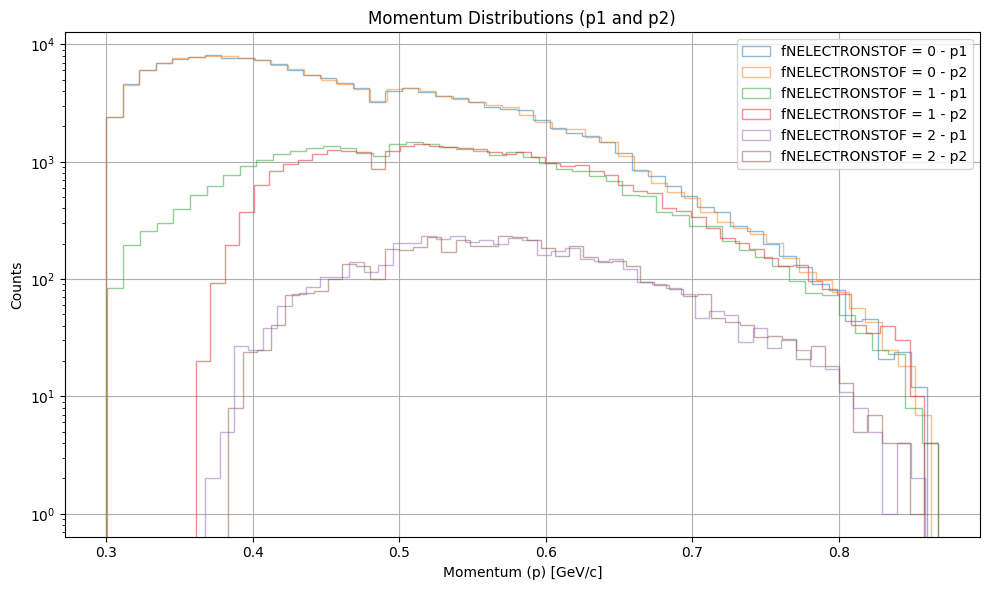

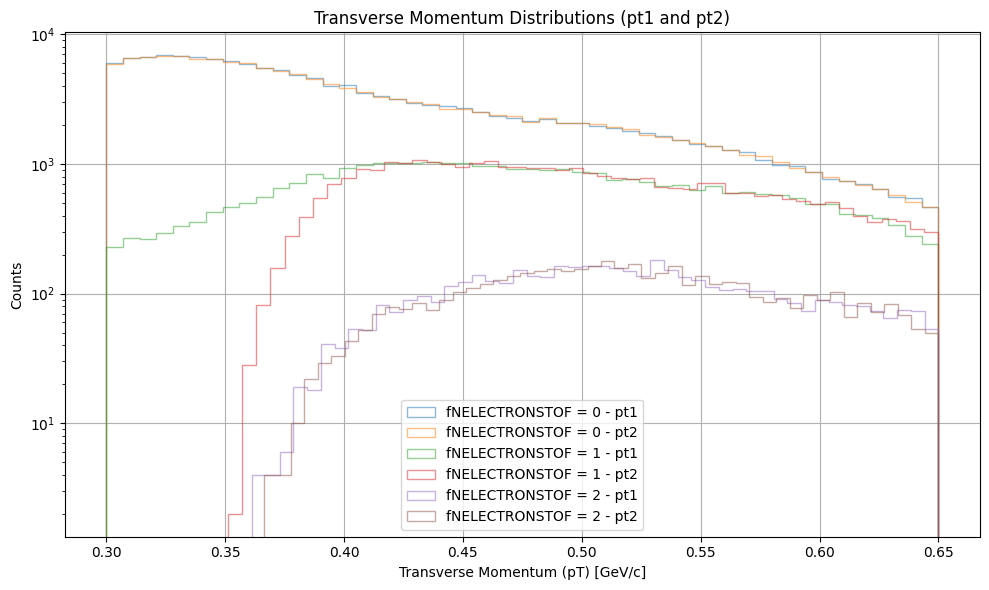

In [31]:
import numpy as np

def add_individual_momenta(dataframes):
    """
    Adds p1, p2, pt1, and pt2 columns to each DataFrame for individual tracks.

    Parameters:
    dataframes (dict): Dictionary of DataFrames, one for each fNELECTRONSTOF value.
    """
    for tof_value, df in dataframes.items():
        # Calculate momentum (p) and transverse momentum (pt) for individual tracks
        df["p1"] = np.sqrt(df["fPX1"]**2 + df["fPY1"]**2 + df["fPZ1"]**2)
        df["p2"] = np.sqrt(df["fPX2"]**2 + df["fPY2"]**2 + df["fPZ2"]**2)
        df["pt1"] = np.sqrt(df["fPX1"]**2 + df["fPY1"]**2)
        df["pt2"] = np.sqrt(df["fPX2"]**2 + df["fPY2"]**2)

def plot_individual_momenta(dataframes):
    """
    Plots p1 and p2, pt1 and pt2 on separate plots for the given DataFrames.

    Parameters:
    dataframes (dict): Dictionary of DataFrames, one for each fNELECTRONSTOF value.
    """
    # Plot p1 and p2
    plt.figure(figsize=(10, 6))
    for tof_value, df in dataframes.items():
        plt.hist(df["p1"], bins=50, alpha=0.5, label=f"fNELECTRONSTOF = {tof_value} - p1", histtype="step")
        plt.hist(df["p2"], bins=50, alpha=0.5, label=f"fNELECTRONSTOF = {tof_value} - p2", histtype="step")
    plt.yscale("log")
    plt.xlabel("Momentum (p) [GeV/c]")
    plt.ylabel("Counts")
    plt.title("Momentum Distributions (p1 and p2)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Plot pt1 and pt2
    plt.figure(figsize=(10, 6))
    for tof_value, df in dataframes.items():
        plt.hist(df["pt1"], bins=50, alpha=0.5, label=f"fNELECTRONSTOF = {tof_value} - pt1", histtype="step")
        plt.hist(df["pt2"], bins=50, alpha=0.5, label=f"fNELECTRONSTOF = {tof_value} - pt2", histtype="step")
    plt.yscale("log")
    plt.xlabel("Transverse Momentum (pT) [GeV/c]")
    plt.ylabel("Counts")
    plt.title("Transverse Momentum Distributions (pt1 and pt2)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# Add p1, p2, pt1, and pt2 to the DataFrames
add_individual_momenta(df_original)

# Plot the individual momentum distributions
plot_individual_momenta(df_original)


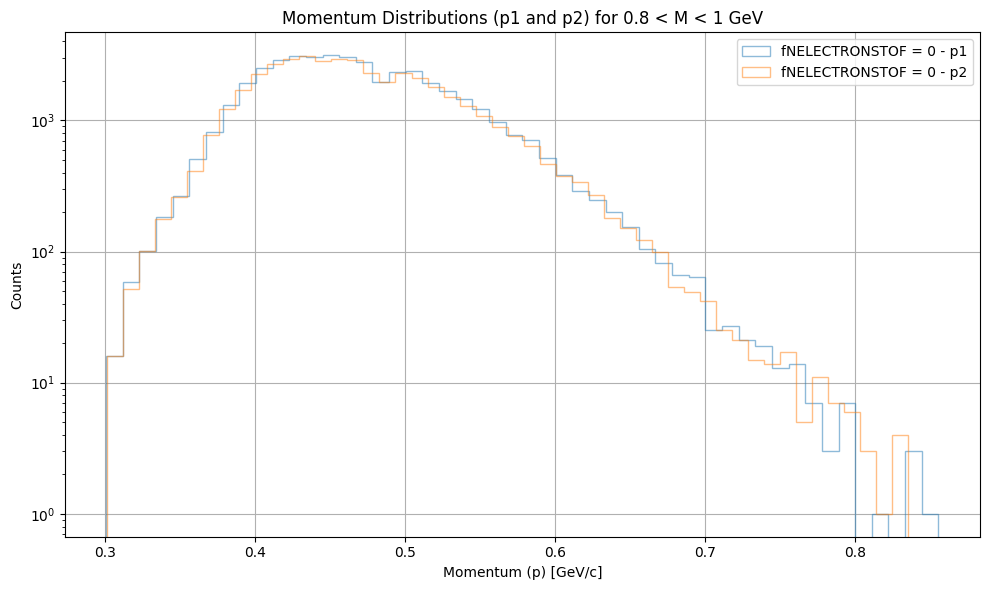

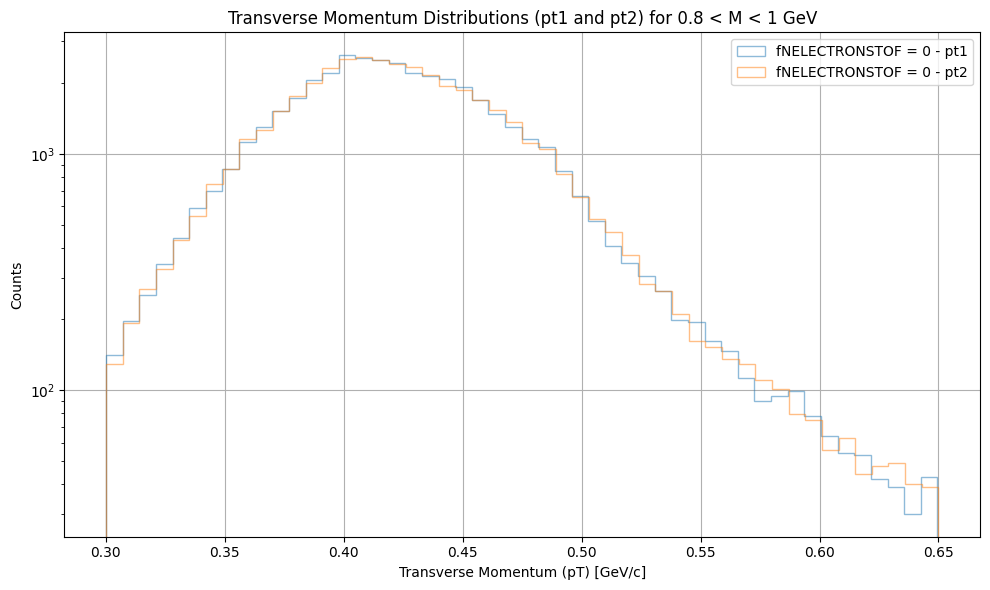

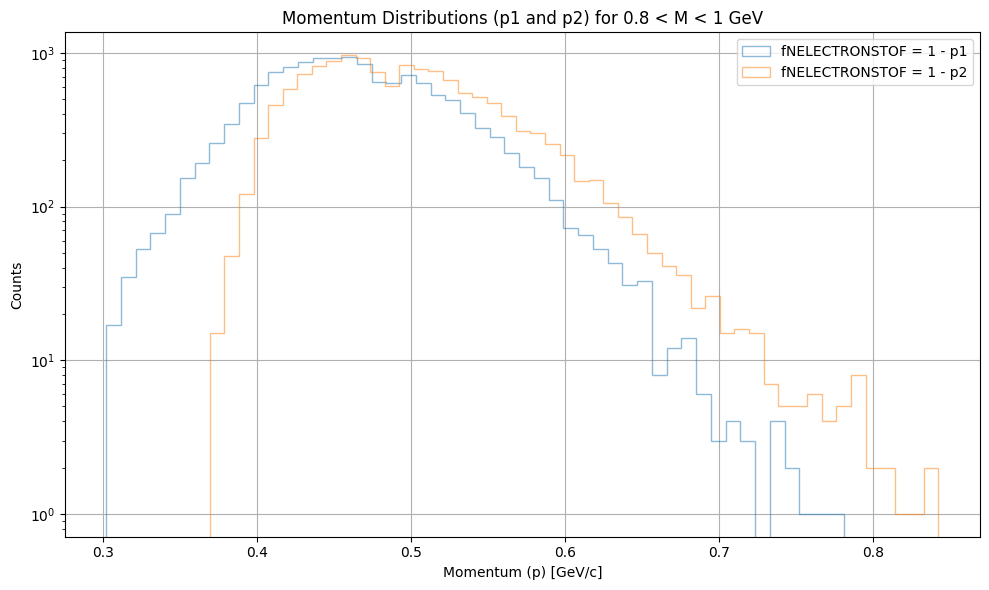

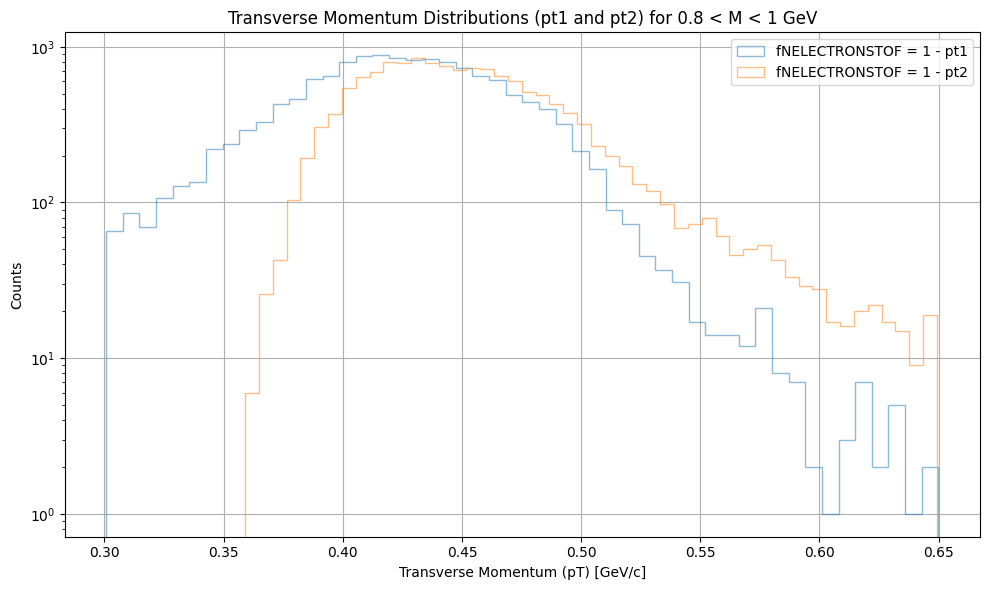

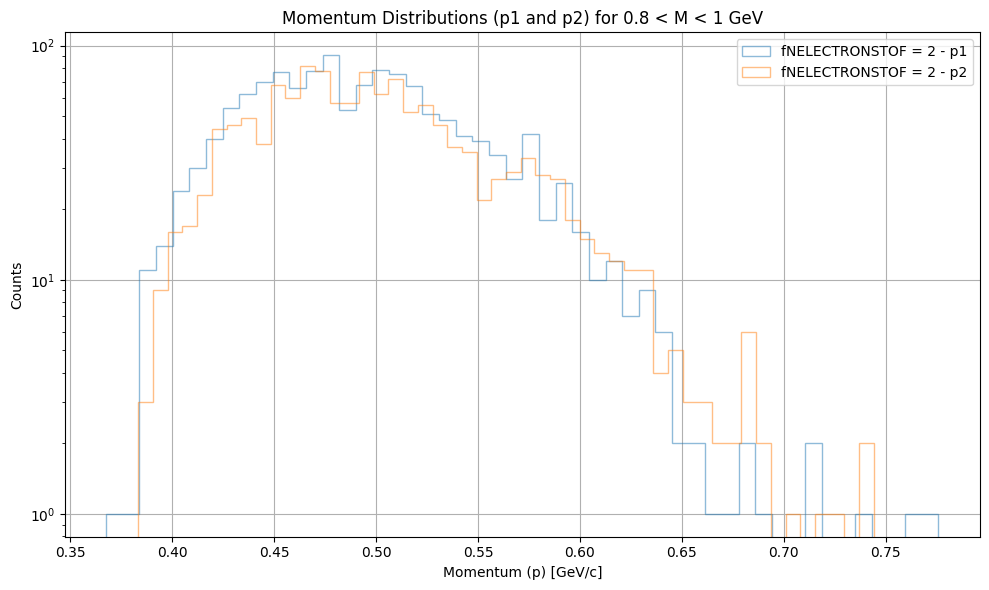

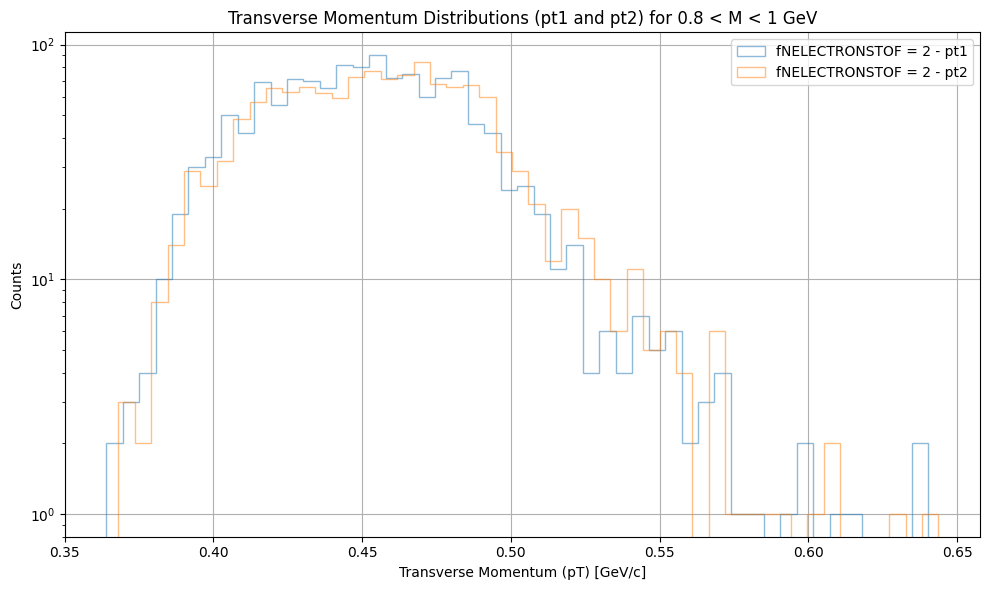

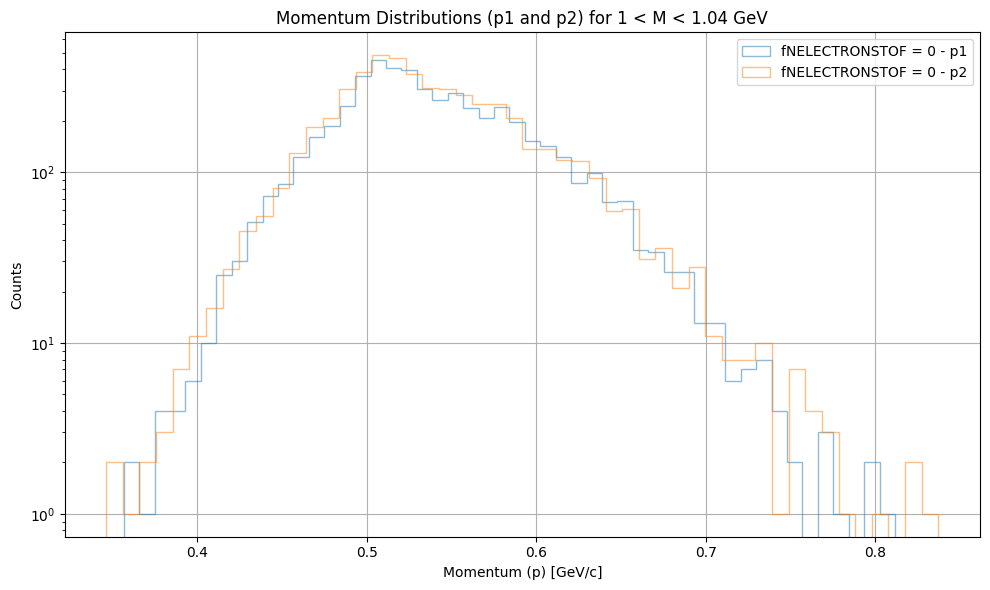

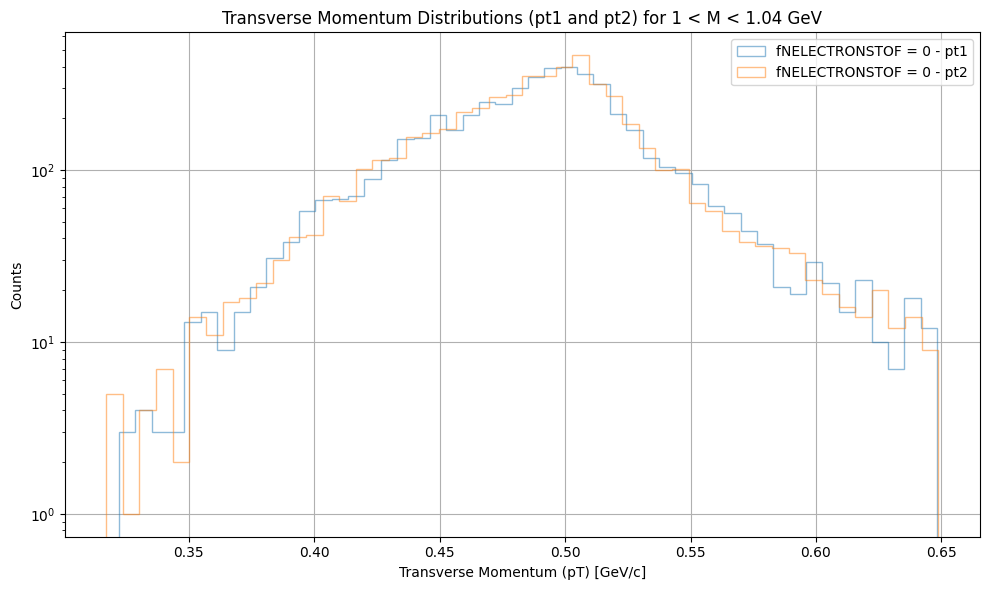

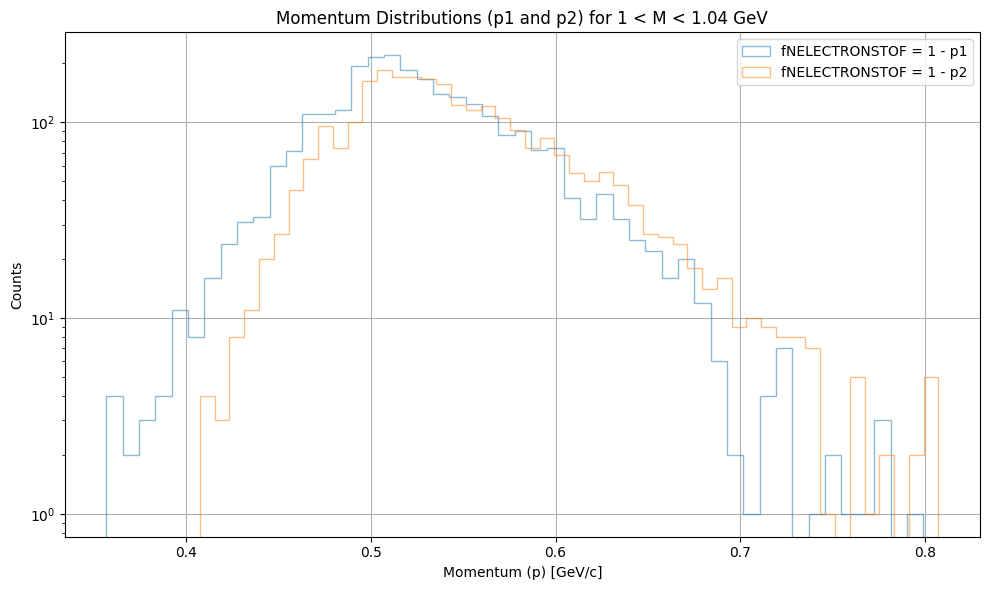

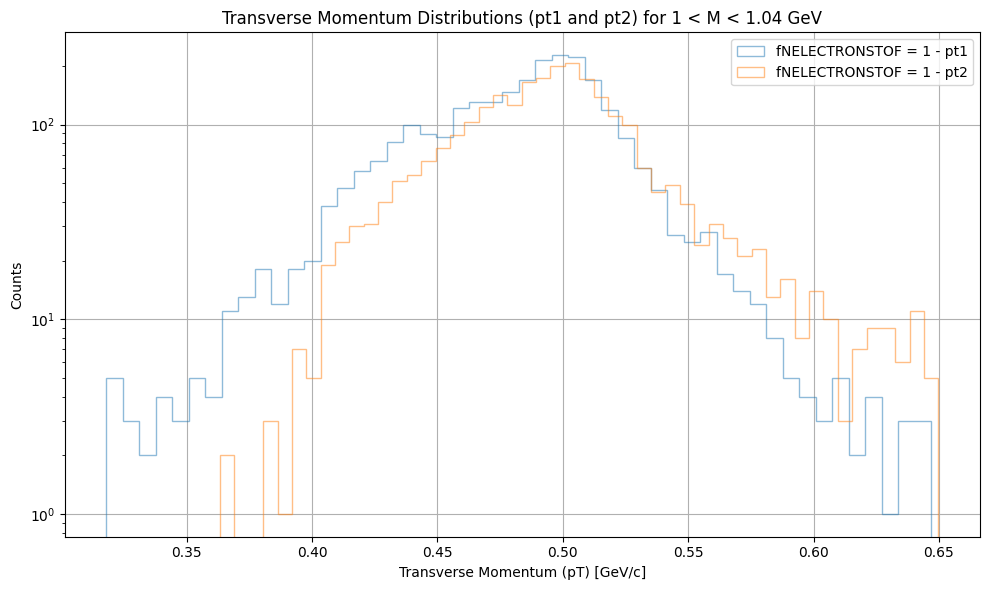

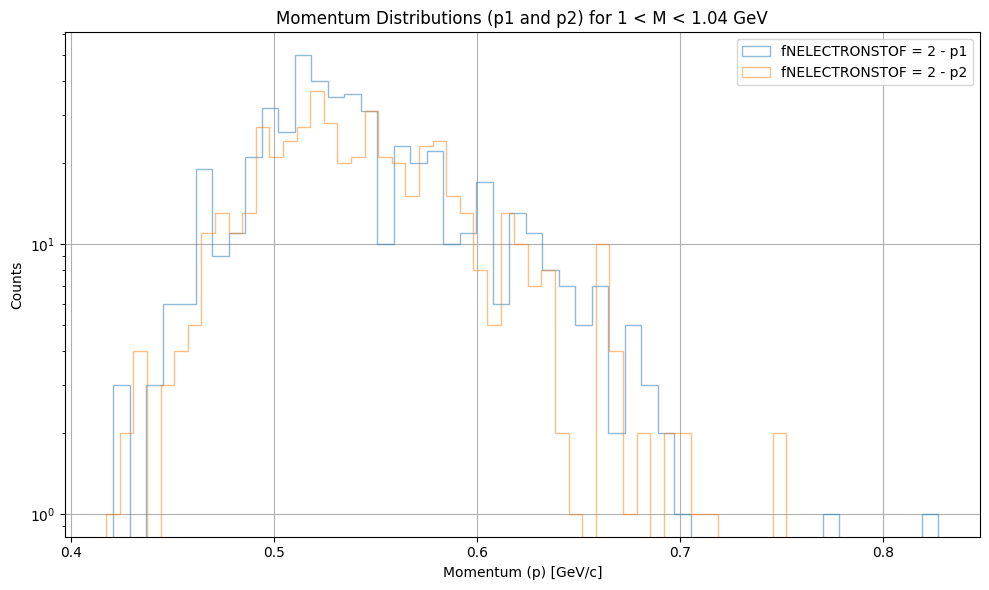

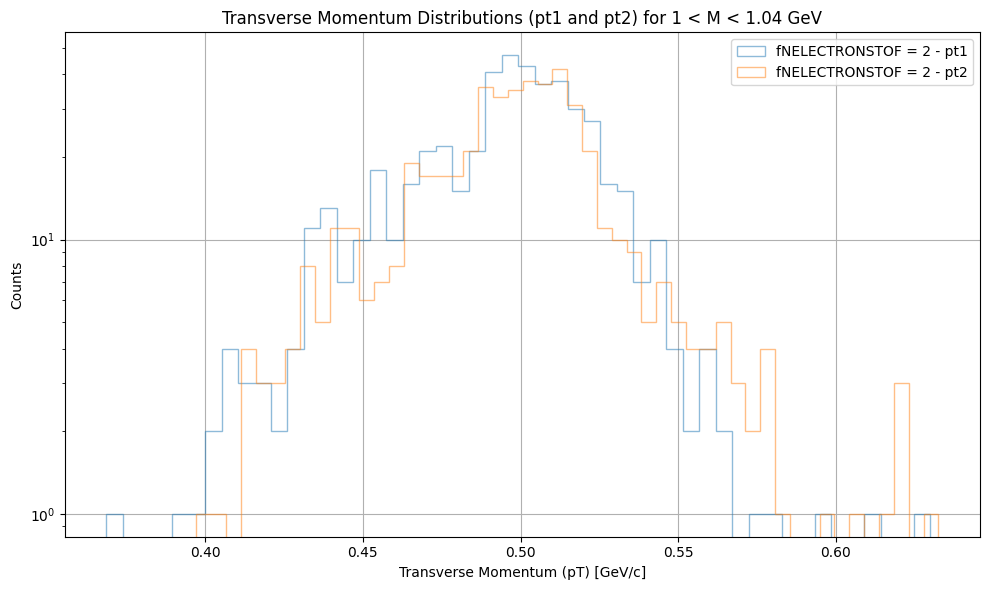

In [32]:
def add_invariant_mass(dataframes):
    """
    Adds the invariant mass (M) column to each DataFrame.

    Parameters:
    dataframes (dict): Dictionary of DataFrames, one for each fNELECTRONSTOF value.
    """
    for tof_value, df in dataframes.items():
        total_energy = df["fPE1"] + df["fPE2"]
        total_px = df["fPX1"] + df["fPX2"]
        total_py = df["fPY1"] + df["fPY2"]
        total_pz = df["fPZ1"] + df["fPZ2"]
        total_p_squared = total_px**2 + total_py**2 + total_pz**2
        df["M"] = np.sqrt(total_energy**2 - total_p_squared)

def plot_filtered_momenta(dataframes, mass_range, title_suffix, output_folder=None):
    """
    Plots p1, p2, pt1, and pt2 for the given DataFrames with the specified invariant mass range.

    Parameters:
    dataframes (dict): Dictionary of DataFrames, one for each fNELECTRONSTOF value.
    mass_range (tuple): Tuple specifying the invariant mass range (min, max).
    title_suffix (str): Suffix to add to the plot titles for context.
    output_folder (str, optional): Folder to save the plots; if None, plots will be shown interactively.
    """
    mass_min, mass_max = mass_range
    
    for tof_value, df in dataframes.items():
        # Filter the DataFrame for the specified invariant mass range
        filtered_df = df[(df["M"] > mass_min) & (df["M"] <= mass_max)]

        # Plot p1 and p2
        plt.figure(figsize=(10, 6))
        plt.hist(filtered_df["p1"], bins=50, alpha=0.5, label=f"fNELECTRONSTOF = {tof_value} - p1", histtype="step")
        plt.hist(filtered_df["p2"], bins=50, alpha=0.5, label=f"fNELECTRONSTOF = {tof_value} - p2", histtype="step")
        plt.yscale("log")
        plt.xlabel("Momentum (p) [GeV/c]")
        plt.ylabel("Counts")
        plt.title(f"Momentum Distributions (p1 and p2) {title_suffix}")
        plt.legend()
        plt.grid()
        plt.tight_layout()
        if output_folder:
            plt.savefig(f"{output_folder}/momentum_p1_p2_{tof_value}_{title_suffix.replace(' ', '_')}.pdf")
        else:
            plt.show()

        # Plot pt1 and pt2
        plt.figure(figsize=(10, 6))
        plt.hist(filtered_df["pt1"], bins=50, alpha=0.5, label=f"fNELECTRONSTOF = {tof_value} - pt1", histtype="step")
        plt.hist(filtered_df["pt2"], bins=50, alpha=0.5, label=f"fNELECTRONSTOF = {tof_value} - pt2", histtype="step")
        plt.yscale("log")
        plt.xlabel("Transverse Momentum (pT) [GeV/c]")
        plt.ylabel("Counts")
        plt.title(f"Transverse Momentum Distributions (pt1 and pt2) {title_suffix}")
        plt.legend()
        plt.grid()
        plt.tight_layout()
        if output_folder:
            plt.savefig(f"{output_folder}/transverse_momentum_pt1_pt2_{tof_value}_{title_suffix.replace(' ', '_')}.pdf")
        else:
            plt.show()

# Add the invariant mass column
add_invariant_mass(df_original)

# Plot the filtered distributions for the two mass ranges
plot_filtered_momenta(df_original, (0.8, 1.0), "for 0.8 < M < 1 GeV")
plot_filtered_momenta(df_original, (1.0, 1.04), "for 1 < M < 1.04 GeV")


In [33]:
df_original[2].head()

,fPX1,fPY1,fPZ1,fPE1,fPX2,fPY2,fPZ2,fPE2,fNCOUNTERPV,p1,p2,pt1,pt2,M
80,-0.495379,0.182227,0.107824,0.538733,0.522859,-0.193218,0.487452,0.740489,2,0.538733,0.740489,0.527833,0.557418,1.131893
97,0.362124,-0.528337,0.066572,0.643976,-0.367282,0.531846,-0.438028,0.780785,2,0.643976,0.780785,0.640526,0.646341,1.375473
187,0.504183,-0.186353,0.406544,0.673948,-0.515286,0.192391,0.283341,0.618722,2,0.673948,0.618722,0.537520,0.550031,1.093112
190,-0.061697,0.461395,-0.176633,0.497887,0.073327,-0.464846,-0.364765,0.595409,2,0.497886,0.595409,0.465501,0.470594,0.949757
235,0.479244,0.102835,0.125527,0.505972,-0.562857,-0.104567,0.203143,0.607462,2,0.505972,0.607462,0.490153,0.572488,1.060526


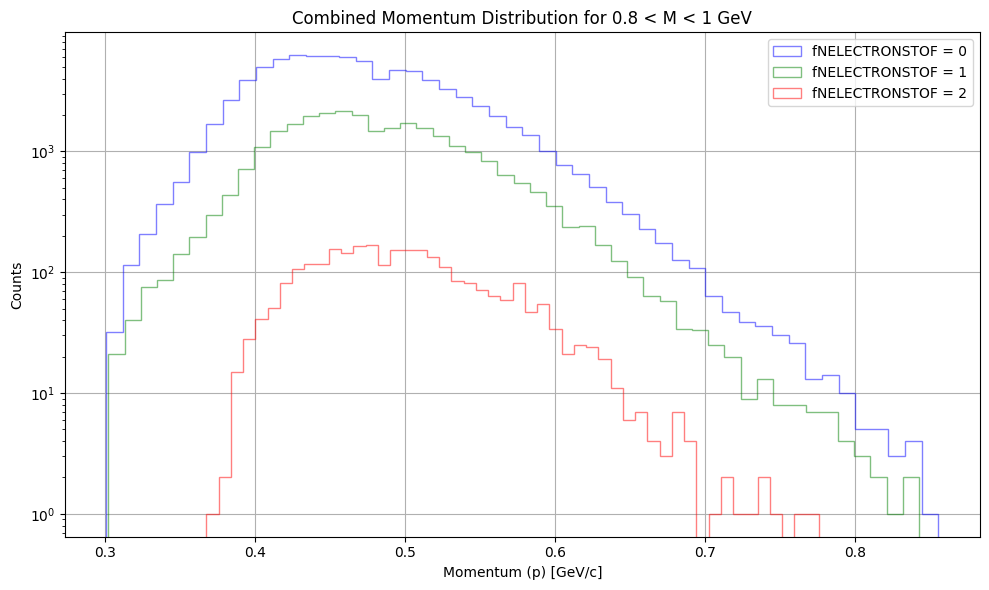

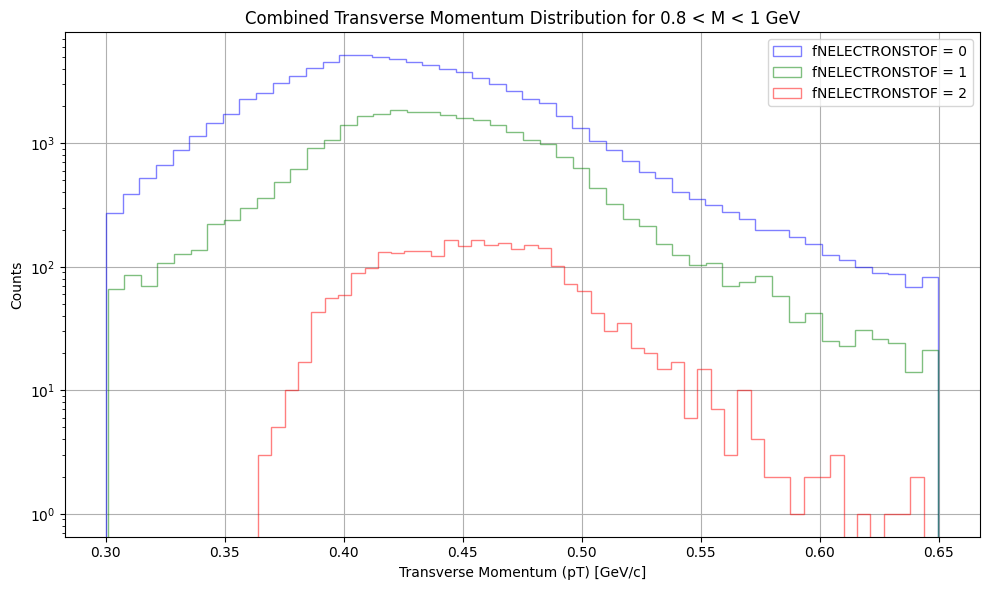

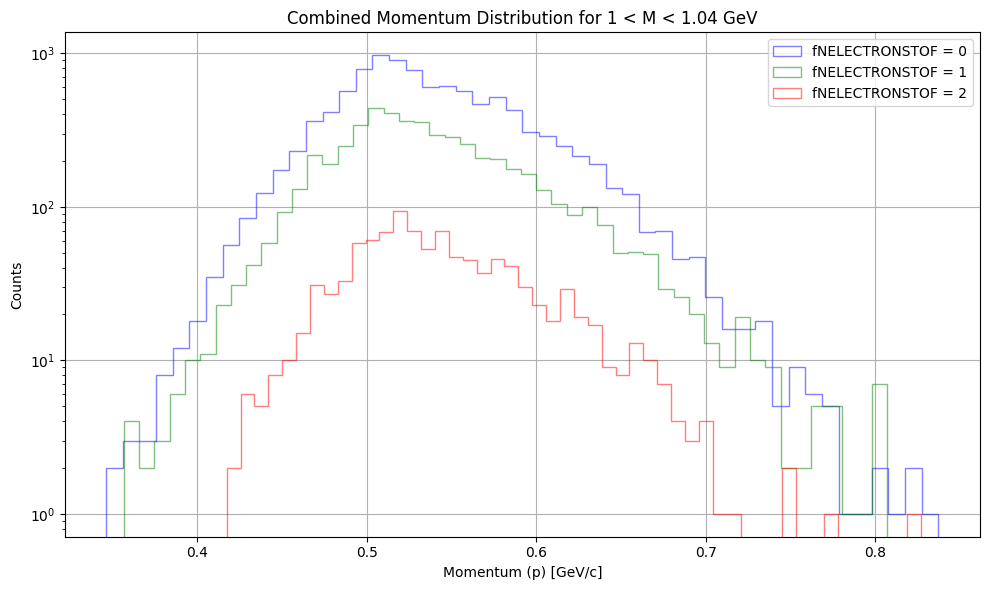

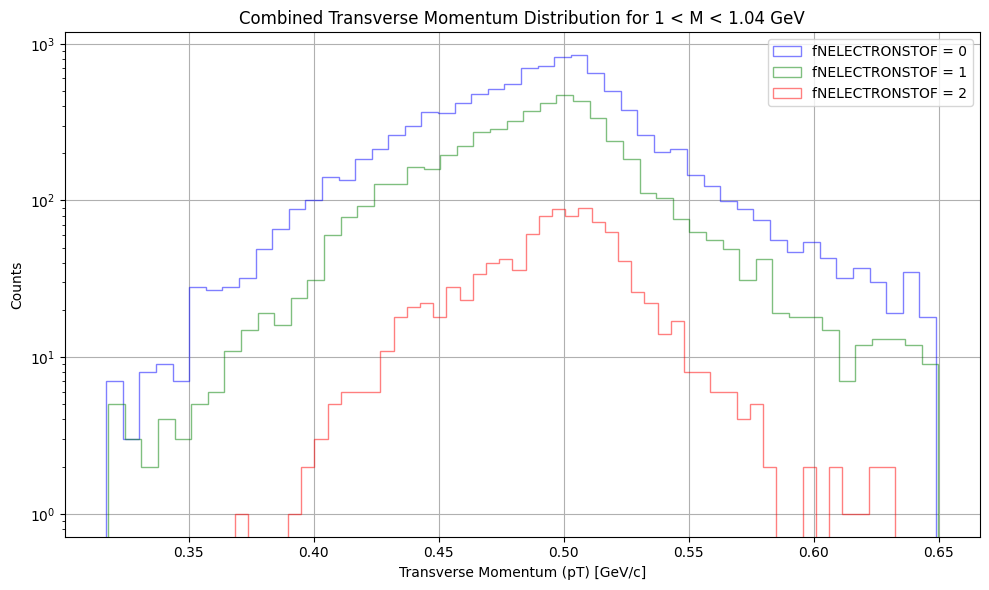

In [34]:
def plot_combined_momenta(dataframes, mass_range, title_suffix, output_folder=None):
    """
    Merges p1 and p2 into p, and pt1 and pt2 into pt, and plots the combined distributions
    for all fNELECTRONSTOF values on the same plots.

    Parameters:
    dataframes (dict): Dictionary of DataFrames, one for each fNELECTRONSTOF value.
    mass_range (tuple): Tuple specifying the invariant mass range (min, max).
    title_suffix (str): Suffix to add to the plot titles for context.
    output_folder (str, optional): Folder to save the plots; if None, plots will be shown interactively.
    """
    mass_min, mass_max = mass_range

    # Colors for the different fNELECTRONSTOF values
    colors = {0: "blue", 1: "green", 2: "red"}

    # Plot merged momentum (p) distributions
    plt.figure(figsize=(10, 6))
    for tof_value, df in dataframes.items():
        # Filter the DataFrame for the specified invariant mass range
        filtered_df = df[(df["M"] > mass_min) & (df["M"] <= mass_max)]

        # Merge p1 and p2 into a single column 'p'
        p = pd.concat([filtered_df["p1"], filtered_df["p2"]])

        # Plot the merged p distribution
        plt.hist(p, bins=50, alpha=0.5, label=f"fNELECTRONSTOF = {tof_value}", histtype="step", color=colors[tof_value])

    plt.yscale("log")
    plt.xlabel("Momentum (p) [GeV/c]")
    plt.ylabel("Counts")
    plt.title(f"Combined Momentum Distribution {title_suffix}")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    if output_folder:
        plt.savefig(f"{output_folder}/combined_momentum_p_{title_suffix.replace(' ', '_')}.pdf")
    else:
        plt.show()

    # Plot merged transverse momentum (pt) distributions
    plt.figure(figsize=(10, 6))
    for tof_value, df in dataframes.items():
        # Filter the DataFrame for the specified invariant mass range
        filtered_df = df[(df["M"] > mass_min) & (df["M"] <= mass_max)]

        # Merge pt1 and pt2 into a single column 'pt'
        pt = pd.concat([filtered_df["pt1"], filtered_df["pt2"]])

        # Plot the merged pt distribution
        plt.hist(pt, bins=50, alpha=0.5, label=f"fNELECTRONSTOF = {tof_value}", histtype="step", color=colors[tof_value])

    plt.yscale("log")
    plt.xlabel("Transverse Momentum (pT) [GeV/c]")
    plt.ylabel("Counts")
    plt.title(f"Combined Transverse Momentum Distribution {title_suffix}")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    if output_folder:
        plt.savefig(f"{output_folder}/combined_transverse_momentum_pt_{title_suffix.replace(' ', '_')}.pdf")
    else:
        plt.show()


# Plot the combined distributions for the two mass ranges
plot_combined_momenta(df_original, (0.8, 1.0), "for 0.8 < M < 1 GeV")
plot_combined_momenta(df_original, (1.0, 1.04), "for 1 < M < 1.04 GeV")


In [35]:
def add_combined_4vector_momenta_and_norm(dataframes):
    """
    Adds `p` (momentum magnitude), `pt` (transverse momentum), and `norm` (4-vector norm) columns
    to the input DataFrames by summing the 4-vectors of the two tracks in each event.

    Parameters:
    dataframes (dict): Dictionary of DataFrames, one for each `fNELECTRONSTOF` value.
    """
    for tof_value, df in dataframes.items():
        # Calculate combined px, py, pz, and energy
        combined_px = df["fPX1"] + df["fPX2"]
        combined_py = df["fPY1"] + df["fPY2"]
        combined_pz = df["fPZ1"] + df["fPZ2"]
        combined_energy = df["fPE1"] + df["fPE2"]

        # Compute p (momentum magnitude)
        df["p"] = np.sqrt(combined_px**2 + combined_py**2 + combined_pz**2)
        
        # Compute pt (transverse momentum)
        df["pt"] = np.sqrt(combined_px**2 + combined_py**2)
        
        # Compute norm of the 4-vector
        df["norm"] = np.sqrt(combined_energy**2 - (combined_px**2 + combined_py**2 + combined_pz**2))
        
        # Update the DataFrame in the dictionary
        dataframes[tof_value] = df

    print("Added `p`, `pt`, and `norm` columns to all DataFrames.")

# Example usage:
add_combined_4vector_momenta_and_norm(df_original)

# Verify the updated DataFrames
for tof_value, subset_df in df_original.items():
    print(f"\nDataFrame for fNELECTRONSTOF = {tof_value}:")
    print(subset_df[["p", "pt", "norm"]].head())


Added `p`, `pt`, and `norm` columns to all DataFrames.

DataFrame for fNELECTRONSTOF = 0:
          p        pt      norm
0  0.081730  0.015648  1.044145
1  0.301845  0.021267  0.675507
3  0.503370  0.014267  1.002446
4  0.186608  0.010298  0.847201
6  0.629309  0.050420  1.208328

DataFrame for fNELECTRONSTOF = 1:
           p        pt      norm
2   0.140921  0.078425  1.110052
5   0.302387  0.032446  0.949829
7   0.256355  0.049433  1.029289
9   0.345060  0.017806  0.861869
15  0.211650  0.046951  0.768541

DataFrame for fNELECTRONSTOF = 2:
            p        pt      norm
80   0.596011  0.029597  1.131893
97   0.371508  0.006239  1.375473
187  0.690001  0.012639  1.093112
190  0.541534  0.012132  0.949757
235  0.339143  0.083631  1.060526


In [36]:
df_original[2].head()

,fPX1,fPY1,fPZ1,fPE1,fPX2,fPY2,fPZ2,fPE2,fNCOUNTERPV,p1,p2,pt1,pt2,M,p,pt,norm
80,-0.495379,0.182227,0.107824,0.538733,0.522859,-0.193218,0.487452,0.740489,2,0.538733,0.740489,0.527833,0.557418,1.131893,0.596011,0.029597,1.131893
97,0.362124,-0.528337,0.066572,0.643976,-0.367282,0.531846,-0.438028,0.780785,2,0.643976,0.780785,0.640526,0.646341,1.375473,0.371508,0.006239,1.375473
187,0.504183,-0.186353,0.406544,0.673948,-0.515286,0.192391,0.283341,0.618722,2,0.673948,0.618722,0.537520,0.550031,1.093112,0.690001,0.012639,1.093112
190,-0.061697,0.461395,-0.176633,0.497887,0.073327,-0.464846,-0.364765,0.595409,2,0.497886,0.595409,0.465501,0.470594,0.949757,0.541534,0.012132,0.949757
235,0.479244,0.102835,0.125527,0.505972,-0.562857,-0.104567,0.203143,0.607462,2,0.505972,0.607462,0.490153,0.572488,1.060526,0.339143,0.083631,1.060526


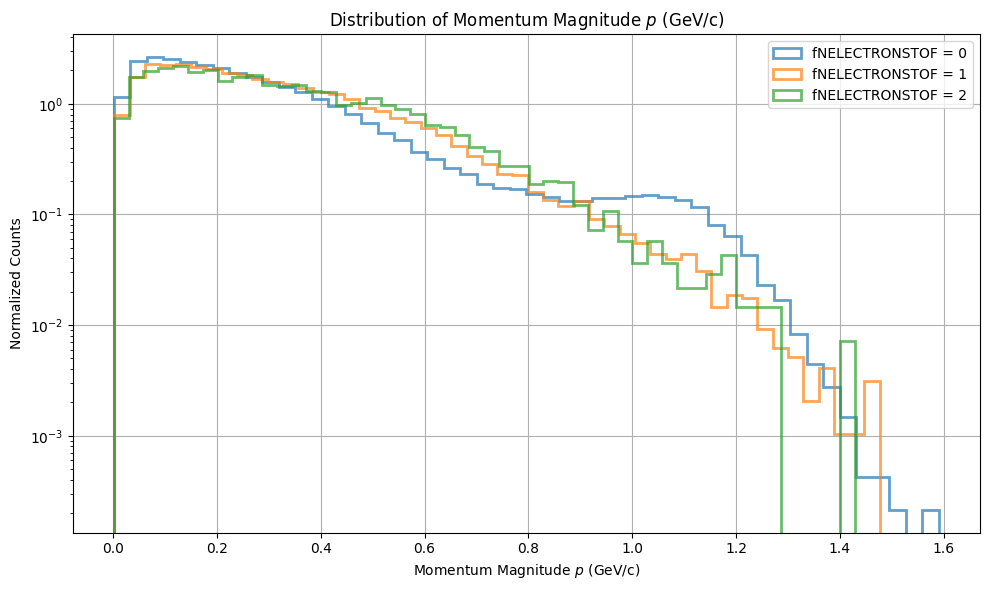

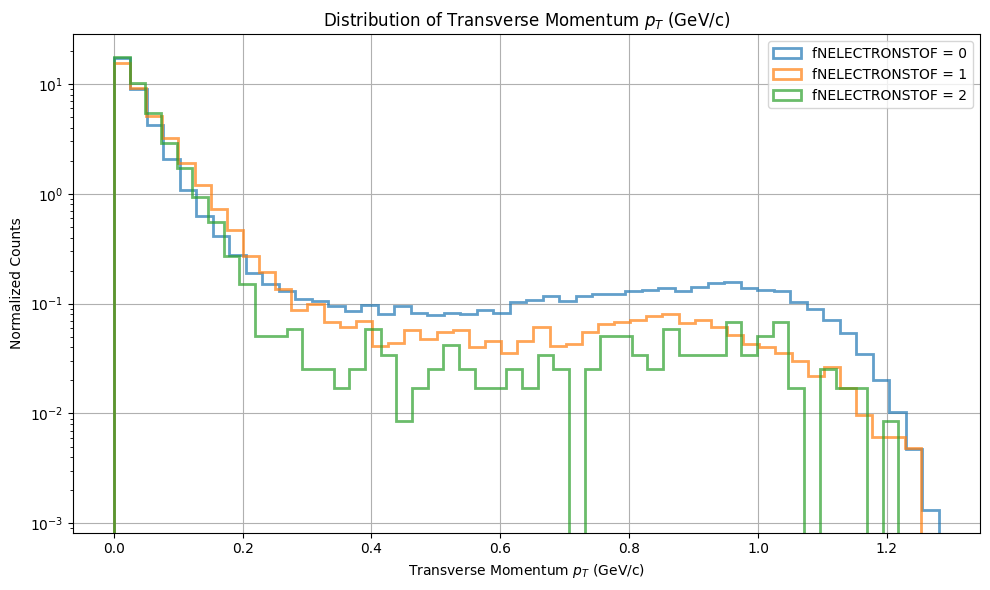

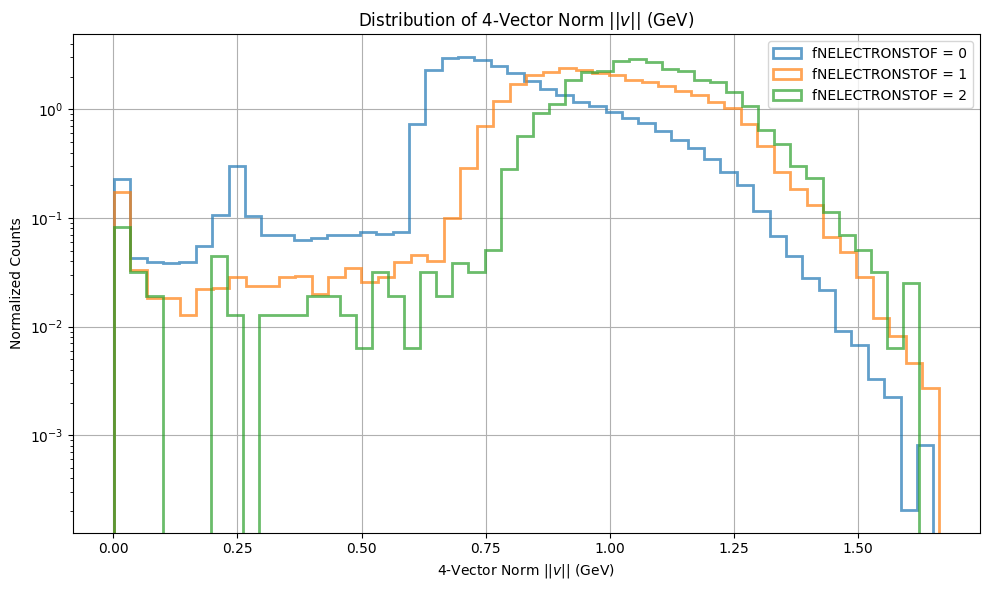

In [37]:
def plot_combined_momenta_and_norm(dataframes):
    """
    Plots the distributions of `p`, `pt`, and `norm` for the three `fNELECTRONSTOF` DataFrames on the same plots.
    The plots are displayed directly instead of being saved.
    
    Parameters:
    dataframes (dict): Dictionary of DataFrames with keys 0, 1, 2 representing `fNELECTRONSTOF`.
    """
    # Define the columns to plot and their labels
    columns_to_plot = {
        "p": "Momentum Magnitude $p$ (GeV/c)",
        "pt": "Transverse Momentum $p_T$ (GeV/c)",
        "norm": "4-Vector Norm $||v||$ (GeV)"
    }

    for column, xlabel in columns_to_plot.items():
        plt.figure(figsize=(10, 6))

        for tof_value, df in dataframes.items():
            plt.hist(
                df[column],
                bins=50,
                alpha=0.7,
                label=f"fNELECTRONSTOF = {tof_value}",
                density=True,  # Normalize the histograms
                histtype="step",
                linewidth=2
            )

        # Add labels and legend
        plt.xlabel(xlabel)
        plt.ylabel("Normalized Counts")
        plt.title(f"Distribution of {xlabel}")
        plt.yscale("log")  # Set y-axis to log scale
        plt.legend()
        plt.grid()
        plt.tight_layout()

        # Show the plot directly
        plt.show()

# Example usage:
plot_combined_momenta_and_norm(df_original)


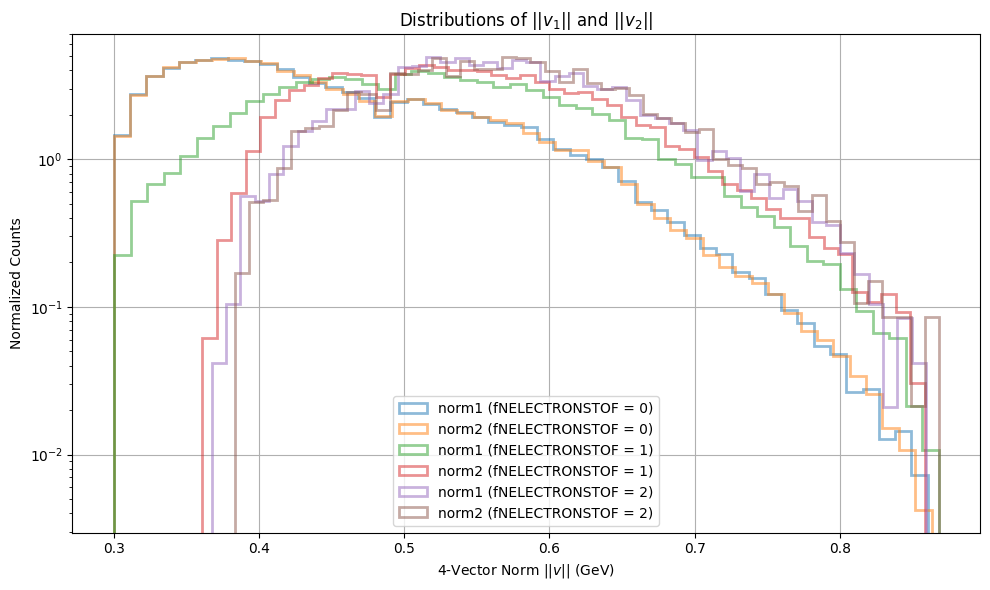

In [38]:
def add_norm1_norm2(dataframes):
    """
    Adds the columns `norm1` and `norm2` to the DataFrames in the input dictionary.
    
    Parameters:
    dataframes (dict): Dictionary of DataFrames with keys 0, 1, 2 representing `fNELECTRONSTOF`.
    """
    for tof_value, df in dataframes.items():
        # Compute norm1 and norm2
        # df["norm1"] = np.sqrt(df["fPE1"]**2 - (df["fPX1"]**2 + df["fPY1"]**2 + df["fPZ1"]**2))
        # df["norm2"] = np.sqrt(df["fPE2"]**2 - (df["fPX2"]**2 + df["fPY2"]**2 + df["fPZ2"]**2))
        df["norm1"] = np.sqrt(df["fPX1"]**2 + df["fPY1"]**2 + df["fPZ1"]**2)
        df["norm2"] = np.sqrt(df["fPX2"]**2 + df["fPY2"]**2 + df["fPZ2"]**2)

def plot_norm1_norm2(dataframes):
    """
    Plots the distributions of `norm1` and `norm2` on the same plot with separate curves
    for `fNELECTRONSTOF = 0, 1, 2`.
    
    Parameters:
    dataframes (dict): Dictionary of DataFrames with keys 0, 1, 2 representing `fNELECTRONSTOF`.
    """
    plt.figure(figsize=(10, 6))

    for tof_value, df in dataframes.items():
        # Plot norm1
        plt.hist(
            df["norm1"],
            bins=50,
            alpha=0.5,
            label=f"norm1 (fNELECTRONSTOF = {tof_value})",
            density=True,  # Normalize the histograms
            histtype="step",
            linewidth=2
        )

        # Plot norm2
        plt.hist(
            df["norm2"],
            bins=50,
            alpha=0.5,
            label=f"norm2 (fNELECTRONSTOF = {tof_value})",
            density=True,  # Normalize the histograms
            histtype="step",
            linewidth=2
        )

    # Add labels and legend
    plt.xlabel("4-Vector Norm $||v||$ (GeV)")
    plt.ylabel("Normalized Counts")
    plt.title("Distributions of $||v_1||$ and $||v_2||$")
    plt.yscale("log")  # Set y-axis to log scale
    plt.legend()
    plt.grid()
    plt.tight_layout()

    # Show the plot directly
    plt.show()

# Add norm1 and norm2 to the DataFrames
add_norm1_norm2(df_original)

# Plot norm1 and norm2
plot_norm1_norm2(df_original)


In [39]:
df_original[2].head()

,fPX1,fPY1,fPZ1,fPE1,fPX2,fPY2,fPZ2,fPE2,fNCOUNTERPV,p1,p2,pt1,pt2,M,p,pt,norm,norm1,norm2
80,-0.495379,0.182227,0.107824,0.538733,0.522859,-0.193218,0.487452,0.740489,2,0.538733,0.740489,0.527833,0.557418,1.131893,0.596011,0.029597,1.131893,0.538733,0.740489
97,0.362124,-0.528337,0.066572,0.643976,-0.367282,0.531846,-0.438028,0.780785,2,0.643976,0.780785,0.640526,0.646341,1.375473,0.371508,0.006239,1.375473,0.643976,0.780785
187,0.504183,-0.186353,0.406544,0.673948,-0.515286,0.192391,0.283341,0.618722,2,0.673948,0.618722,0.537520,0.550031,1.093112,0.690001,0.012639,1.093112,0.673948,0.618722
190,-0.061697,0.461395,-0.176633,0.497887,0.073327,-0.464846,-0.364765,0.595409,2,0.497886,0.595409,0.465501,0.470594,0.949757,0.541534,0.012132,0.949757,0.497886,0.595409
235,0.479244,0.102835,0.125527,0.505972,-0.562857,-0.104567,0.203143,0.607462,2,0.505972,0.607462,0.490153,0.572488,1.060526,0.339143,0.083631,1.060526,0.505972,0.607462


In [40]:
def create_filtered_dataframes(dataframes):
    """
    Creates six filtered DataFrames (two for each original DataFrame) based on invariant mass and
    kinematic conditions.

    Parameters:
    dataframes (dict): Dictionary of DataFrames with keys 0, 1, 2 representing `fNELECTRONSTOF`.

    Returns:
    dict: Dictionary containing six filtered DataFrames with keys
          `df_filtered_lower[0,1,2]` and `df_filtered_phi[0,1,2]`.
    """
    df_filtered_lower = []
    df_filtered_phi = []

    # Loop through each fNELECTRONSTOF value
    for tof_value, df in dataframes.items():
        # Define the conditions
        mass_condition_lower = (0.8 < df["M"]) & (df["M"] < 1.0)
        mass_condition_phi = (1.0 < df["M"]) & (df["M"] < 1.04)
        pt_condition = (0.4 < df["pt1"]) & (df["pt1"] < 0.6) & \
                       (0.4 < df["pt2"]) & (df["pt2"] < 0.6)
        p_condition = (0.45 < df["p1"]) & (df["p1"] < 0.65) & \
                      (0.45 < df["p2"]) & (df["p2"] < 0.65)

        # Filtered by lower mass condition and kinematic conditions
        df_lower = df[mass_condition_lower & pt_condition & p_condition]
        df_filtered_lower.append(df_lower)

        # Filtered by phi mass condition and kinematic conditions
        df_phi = df[mass_condition_phi & pt_condition & p_condition]
        df_filtered_phi.append(df_phi)

    return df_filtered_lower, df_filtered_phi

# Create the filtered DataFrames
df_filtered_lower, df_filtered_phi = create_filtered_dataframes(df_original)


In [41]:
df_filtered_phi[0].head()

,fPX1,fPY1,fPZ1,fPE1,fPX2,fPY2,fPZ2,fPE2,fNCOUNTERPV,p1,p2,pt1,pt2,M,p,pt,norm,norm1,norm2
3,-0.490760,-0.127637,-0.275347,0.577020,0.477005,0.131425,-0.227821,0.544710,2,0.577020,0.544709,0.507086,0.494779,1.002446,0.503370,0.014267,1.002446,0.577020,0.544709
10,-0.189623,0.514371,-0.309481,0.629534,0.134792,-0.452662,-0.140655,0.492805,2,0.629534,0.492804,0.548210,0.472305,1.024796,0.457643,0.082549,1.024796,0.629534,0.492804
21,0.307177,0.377516,0.072478,0.492066,-0.335084,-0.324916,-0.256377,0.532524,2,0.492066,0.532524,0.486699,0.466746,1.006191,0.193299,0.059545,1.006191,0.492066,0.532524
116,0.000421,0.477694,-0.180863,0.510788,-0.008255,-0.492749,0.152753,0.515949,2,0.510787,0.515949,0.477695,0.492818,1.026212,0.032836,0.016971,1.026212,0.510787,0.515949
148,-0.205425,0.352422,0.343487,0.533277,0.197722,-0.353234,-0.293080,0.499764,2,0.533277,0.499764,0.407922,0.404806,1.031781,0.050999,0.007746,1.031781,0.533277,0.499764


In [42]:
df_filtered_lower[0].head()

,fPX1,fPY1,fPZ1,fPE1,fPX2,fPY2,fPZ2,fPE2,fNCOUNTERPV,p1,p2,pt1,pt2,M,p,pt,norm,norm1,norm2
22,0.417702,-0.188528,0.267732,0.530753,-0.372723,0.166030,0.316806,0.516580,2,0.530752,0.516580,0.458277,0.408030,0.867578,0.586697,0.050291,0.867578,0.530752,0.516580
52,0.379965,0.303154,-0.058889,0.489636,-0.334194,-0.332120,-0.061950,0.475213,2,0.489636,0.475213,0.486082,0.471157,0.955719,0.132424,0.054166,0.955719,0.489636,0.475213
70,0.220688,0.387111,-0.094684,0.455548,-0.221077,-0.387607,-0.259422,0.516153,2,0.455548,0.516153,0.445599,0.446222,0.904882,0.354107,0.000629,0.904882,0.455548,0.516153
75,-0.459602,0.055139,-0.054600,0.466107,0.439231,-0.055423,-0.326131,0.549870,2,0.466107,0.549870,0.462898,0.442714,0.941721,0.381276,0.020374,0.941721,0.466107,0.549870
127,-0.298208,0.429615,0.188565,0.555926,0.424046,-0.160881,0.015924,0.453818,2,0.555926,0.453818,0.522970,0.453539,0.943247,0.360373,0.296738,0.943247,0.555926,0.453818


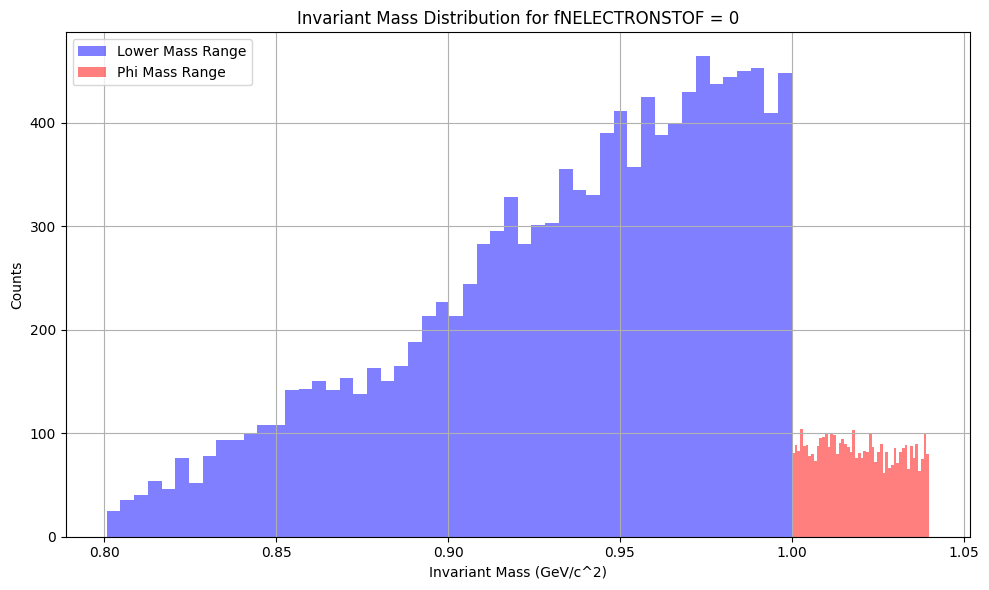

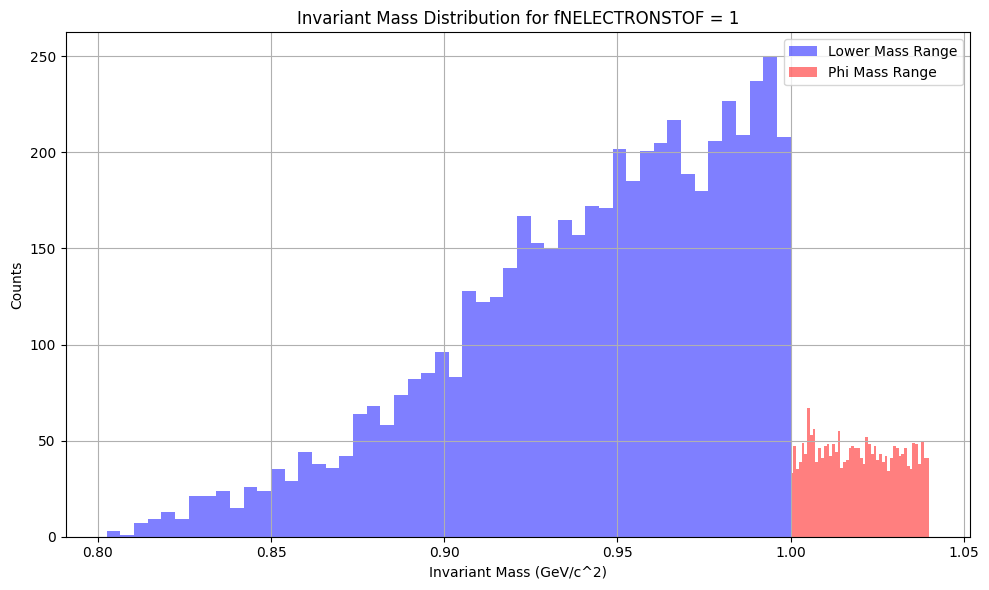

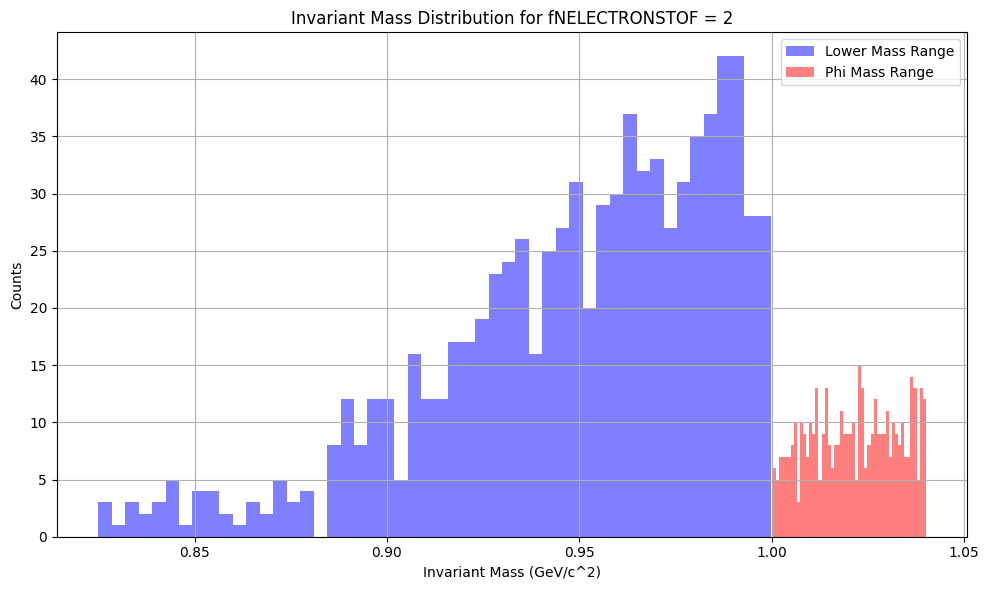

In [43]:
import matplotlib.pyplot as plt

# Function to plot invariant mass distributions
def plot_invariant_mass_distributions(filtered_lower, filtered_phi):
    """
    Plots the invariant mass distributions for the lower and phi mass ranges
    for fNELECTRONSTOF = 0, 1, and 2.

    Parameters:
    filtered_lower (list): List of DataFrames for the lower mass range.
    filtered_phi (list): List of DataFrames for the phi mass range.
    """
    for tof_value in [0, 1, 2]:
        plt.figure(figsize=(10, 6))
        # Plot lower mass range
        plt.hist(filtered_lower[tof_value]["M"], bins=50, alpha=0.5, label="Lower Mass Range", color="blue")
        # Plot phi mass range
        plt.hist(filtered_phi[tof_value]["M"], bins=50, alpha=0.5, label="Phi Mass Range", color="red")
        # Labeling
        plt.xlabel("Invariant Mass (GeV/c^2)")
        plt.ylabel("Counts")
        plt.title(f"Invariant Mass Distribution for fNELECTRONSTOF = {tof_value}")
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()

# Plot the invariant mass distributions for the filtered DataFrames
plot_invariant_mass_distributions(df_filtered_lower, df_filtered_phi)


In [44]:
# Print the feature names used during training
print("Feature names used during training:")
print(rf_model_filtered.feature_names_in_)


Feature names used during training:
['pT (e+e-)' 'Squared Momentum Difference' 'Acoplanarity'
 'Energy Asymmetry' 'Longitudinal Momentum Difference' 'Opening Angle']


In [45]:
import numpy as np

def create_feature_only_dataframes_from_filtered(filtered_dataframes):
    """
    Creates feature-only DataFrames from a dictionary of filtered DataFrames.

    Parameters:
    filtered_dataframes (list): List of filtered DataFrames, e.g., df_filtered_phi or df_filtered_lower.

    Returns:
    list: List of feature-only DataFrames corresponding to the input filtered DataFrames.
    """
    feature_dataframes = []

    for df in filtered_dataframes:
        # Calculate features
        dot_product = df["fPX1"] * df["fPX2"] + df["fPY1"] * df["fPY2"] + df["fPZ1"] * df["fPZ2"]
        magnitude1 = np.sqrt(df["fPX1"]**2 + df["fPY1"]**2 + df["fPZ1"]**2)
        magnitude2 = np.sqrt(df["fPX2"]**2 + df["fPY2"]**2 + df["fPZ2"]**2)
        opening_angle = np.arccos(dot_product / (magnitude1 * magnitude2))
        longitudinal_momentum_difference = abs(df["fPZ1"] - df["fPZ2"])
        energy_asymmetry = (df["fPE1"] - df["fPE2"]) / (df["fPE1"] + df["fPE2"])
        phi1 = np.arctan2(df["fPY1"], df["fPX1"])
        phi2 = np.arctan2(df["fPY2"], df["fPX2"])
        acoplanarity = 1 - np.abs(phi1 - phi2) / np.pi
        squared_momentum_difference = ((df["fPX1"] - df["fPX2"])**2 + 
                                        (df["fPY1"] - df["fPY2"])**2 + 
                                        (df["fPZ1"] - df["fPZ2"])**2)
        pt_ee = ((df["fPX1"] + df["fPX2"])**2 + (df["fPY1"] + df["fPY2"])**2)**0.5

        # Create feature-only DataFrame
        feature_df = pd.DataFrame({
            "pT (e+e-)": pt_ee,
            "Acoplanarity": acoplanarity,
            "Squared Momentum Difference": squared_momentum_difference,
            "Longitudinal Momentum Difference": longitudinal_momentum_difference,
            "Energy Asymmetry": energy_asymmetry,
            "Opening Angle": opening_angle,
        })
        feature_dataframes.append(feature_df)

    return feature_dataframes

# Example usage
df_features_lower = create_feature_only_dataframes_from_filtered(df_filtered_lower)
df_features_phi = create_feature_only_dataframes_from_filtered(df_filtered_phi)

# Print the number of rows in each subset for verification
for i, feature_df in enumerate(df_features_lower):
    print(f"Number of events in df_features_lower[{i}]: {len(feature_df)}")
    print(feature_df.head())

for i, feature_df in enumerate(df_features_phi):
    print(f"Number of events in df_features_phi[{i}]: {len(feature_df)}")
    print(feature_df.head())


Number of events in df_features_lower[0]: 12058
     pT (e+e-)  Acoplanarity  Squared Momentum Difference  \
22    0.050291     -0.001562                     0.752892   
52    0.054166      0.034650                     0.913605   
70    0.000629     -0.000066                     0.822483   
75    0.020374     -0.001948                     0.893854   
127   0.296738      0.191433                     0.900141   

     Longitudinal Momentum Difference  Energy Asymmetry  Opening Angle  
22                           0.049075          0.013532       1.952652  
52                           0.003061          0.014949       2.867845  
70                           0.164738         -0.062370       2.405607  
75                           0.271531         -0.082446       2.389250  
127                          0.172641          0.101122       2.439174  
Number of events in df_features_lower[1]: 5373
    pT (e+e-)  Acoplanarity  Squared Momentum Difference  \
5    0.032446     -0.019543             

In [46]:
df_features_phi[1].head()

,pT (e+e-),Acoplanarity,Squared Momentum Difference,Longitudinal Momentum Difference,Energy Asymmetry,Opening Angle
7,0.049433,0.003302,1.075220,0.338184,0.118444,2.714030
206,0.023464,-0.012040,1.063063,0.027227,0.006169,2.681472
269,0.004968,-0.002808,1.058361,0.448702,-0.018444,3.077524
399,0.004622,0.000348,1.019601,0.352441,-0.082630,2.706250
482,0.027405,0.013159,1.008372,0.381460,0.000449,3.030200


In [47]:
import matplotlib.pyplot as plt
import numpy as np
import os

def analyze_phi_predictions(feature_dataframes, original_df, model, output_folder='betterAnalysis'):
    """
    Passes feature DataFrames through the model, separates predictions into signal and background,
    and plots the invariant mass and pT distributions for both signal and background, as well as a 2D
    plot of invariant mass vs pT for predicted signal. Adds an extra plot for invariant mass distribution
    if pT > 0.3 GeV. This function focuses only on `df_features_phi`.

    Parameters:
    feature_dataframes (list): List containing prepared feature DataFrames for `df_features_phi`.
    original_df (list): List containing the corresponding original DataFrames (`df_filtered_phi`).
    model: Trained Random Forest model.
    output_folder (str): Folder to save the generated plots.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Ensure feature alignment
    expected_features = model.feature_names_in_

    for i, features_df in enumerate(feature_dataframes):
        # Align test DataFrame with training features
        features_df = features_df[expected_features]
        
        # Predict signal (phi) vs background
        predictions = model.predict(features_df)
        
        # Retrieve the corresponding events from the original DataFrame
        filtered_df = original_df[i].copy()
        
        # Add predictions to the filtered original DataFrame
        filtered_df["Prediction"] = predictions
        
        # Separate predicted signal and background
        signal_df = filtered_df[filtered_df["Prediction"] == 1]
        background_df = filtered_df[filtered_df["Prediction"] == 0]
        
        # Compute invariant mass
        def compute_invariant_mass(df):
            if df.empty:
                return np.array([])  # Return an empty array if the DataFrame is empty
            total_energy = df["fPE1"] + df["fPE2"]
            total_px = df["fPX1"] + df["fPX2"]
            total_py = df["fPY1"] + df["fPY2"]
            total_pz = df["fPZ1"] + df["fPZ2"]
            total_p = np.sqrt(total_px**2 + total_py**2 + total_pz**2)
            return np.sqrt(total_energy**2 - total_p**2)
        
        signal_invariant_mass = compute_invariant_mass(signal_df)
        background_invariant_mass = compute_invariant_mass(background_df)

        # Compute transverse momentum (pT)
        signal_pt = np.sqrt((signal_df["fPX1"] + signal_df["fPX2"])**2 + (signal_df["fPY1"] + signal_df["fPY2"])**2)
        background_pt = np.sqrt((background_df["fPX1"] + background_df["fPX2"])**2 + (background_df["fPY1"] + background_df["fPY2"])**2)

        # Filter for invariant mass if pT > 0.3 GeV
        signal_pt_cut = signal_df[signal_pt > 0.3]
        background_pt_cut = background_df[background_pt > 0.3]
        signal_invariant_mass_pt_cut = compute_invariant_mass(signal_pt_cut)
        background_invariant_mass_pt_cut = compute_invariant_mass(background_pt_cut)

        # Plot invariant mass distributions with fine binning
        if len(signal_invariant_mass) > 0 or len(background_invariant_mass) > 0:
            plt.figure(figsize=(10, 6))
            bins = np.arange(1., 1.1, 0.002)  # Fine binning: 5 MeV bins
            if len(signal_invariant_mass) > 0:
                plt.hist(signal_invariant_mass, bins=bins, color='blue', alpha=0.5, label='Predicted Signal (\u03D5(1020))', density=True)
            if len(background_invariant_mass) > 0:
                plt.hist(background_invariant_mass, bins=bins, color='red', alpha=0.5, label='Predicted Background', density=True)
            plt.xlabel("Invariant Mass (GeV/c$^2$)")
            plt.ylabel("Counts / bin")
            plt.legend()
            plt.grid()
            plt.tight_layout()
            plt.savefig(f"{output_folder}/invariant_mass_phi_{i}.pdf")
            plt.close()

        # Plot pT distributions
        if len(signal_pt) > 0 or len(background_pt) > 0:
            plt.figure(figsize=(10, 6))
            bins = np.linspace(0, 0.15, 50)  # Adjust binning for better resolution
            if len(signal_pt) > 0:
                plt.hist(signal_pt, bins=bins, color='blue', alpha=0.5, label='Predicted Signal (\u03D5(1020))', density=True)
            if len(background_pt) > 0:
                plt.hist(background_pt, bins=bins, color='red', alpha=0.5, label='Predicted Background', density=True)
            plt.xlabel("Transverse Momentum $p_T$ (GeV/c)")
            plt.ylabel("Counts / bin")
            plt.legend()
            plt.grid()
            plt.tight_layout()
            plt.savefig(f"{output_folder}/pt_phi_{i}.pdf")
            plt.close()

        # 2D plot: invariant mass vs pT for predicted signal
        if len(signal_invariant_mass) > 0 and len(signal_pt) > 0:
            plt.figure(figsize=(10, 8))
            plt.hist2d(signal_invariant_mass, signal_pt, bins=(50, 50), cmap='viridis')
            plt.colorbar(label="Counts")
            plt.xlabel("Invariant Mass (GeV/c$^2$)")
            plt.ylabel("Transverse Momentum $p_T$ (GeV/c)")
            plt.title("Predicted Signal (\u03D5(1020))")
            plt.tight_layout()
            plt.savefig(f"{output_folder}/invariant_mass_vs_pt_phi_{i}.pdf")
            plt.close()

        # Plot invariant mass distributions for events with pT > 0.3 GeV
        if len(signal_invariant_mass_pt_cut) > 0 or len(background_invariant_mass_pt_cut) > 0:
            plt.figure(figsize=(10, 6))
            bins = np.arange(1., 1.1, 0.002)  # Fine binning: 5 MeV bins
            if len(signal_invariant_mass_pt_cut) > 0:
                plt.hist(signal_invariant_mass_pt_cut, bins=bins, color='blue', alpha=0.5, label='Predicted Signal (\u03D5(1020)) with $p_T > 0.3$ GeV', density=True)
            if len(background_invariant_mass_pt_cut) > 0:
                plt.hist(background_invariant_mass_pt_cut, bins=bins, color='red', alpha=0.5, label='Predicted Background with $p_T > 0.3$ GeV', density=True)
            plt.xlabel("Invariant Mass (GeV/c$^2$)")
            plt.ylabel("Counts / bin")
            plt.legend()
            plt.grid()
            plt.tight_layout()
            plt.savefig(f"{output_folder}/invariant_mass_pt_cut_phi_{i}.pdf")
            plt.close()

    print(f"Plots saved to folder: {output_folder}")


In [48]:
# Example usage
analyze_phi_predictions(df_features_phi, df_filtered_phi, rf_model_filtered)


Plots saved to folder: betterAnalysis
